**target** - Фьючерс на мукомольную пшеницу №2 - (BL2c1)

**feature_1** - SGE Gold T+D CNY Cash Spot - 1 (XAUTD=SGEX)

**feature_2** - Фьючерс на нефть Brent - Дек. '24 (LCOZ4)

**feature_3** - Фьючерс на газойль Лондон - Нояб. '24 (LGOX4)

**feature_4** - US Soybean Meal Futures - Март '25 (SMc3)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### Все данные взяты по дням за последние 10 лет, с 16.10.2014 по 23.10.2024 (небольшой хвост в 2014 году взят для адекватной работы метода ffill)

In [2]:
df_target = pd.read_csv("target.csv")
df_target

Дата    Цена   Откр.   Макс.    Мин.   Объём  Изм. %
0     23.10.2024  223,75  222,50  224,25  221,00  39,99K   0,11%
1     22.10.2024  223,50  223,50  224,25  221,50  47,22K  -0,33%
2     21.10.2024  224,25  227,50  228,00  223,50  33,52K  -0,99%
3     18.10.2024  226,50  231,00  231,25  226,00  36,55K  -1,63%
4     17.10.2024  230,25  228,25  230,50  226,75  28,71K   1,10%
...          ...     ...     ...     ...     ...     ...     ...
2562  22.10.2014  167,75  164,00  168,00  163,75  24,87K   2,29%
2563  21.10.2014  164,00  160,00  164,50  160,00  17,79K   2,66%
2564  20.10.2014  159,75  159,25  160,00  158,00  16,64K  -0,16%
2565  17.10.2014  160,00  160,00  162,00  159,25  19,28K   0,31%
2566  16.10.2014  159,50  157,00  160,50  156,75  26,66K   0,95%

[2567 rows x 7 columns]

# Анализ данных

In [3]:
df_target["Дата"] = pd.to_datetime(df_target["Дата"], dayfirst=True)

print("Первый день в целевых данных:\n", df_target.iloc[-1]["Дата"].date())
print("Последний день в целевых данных:\n", df_target.iloc[0]["Дата"].date())

Первый день в целевых данных:
 2014-10-16
Последний день в целевых данных:
 2024-10-23


Посмотрим количество пропущенных дней в целевых данных

In [4]:
all_dates_range = pd.date_range(start="23.10.2014", end="23.10.2024")[::-1]

df_target_full = df_target.merge(pd.Series(all_dates_range, name="Дата"), how="right")

missing_values_num = df_target_full["Цена"].isna().sum()

print("Кол-во дней с пропущенной ценой:\n", missing_values_num)
print("Общее кол-во дней:\n", len(all_dates_range))
print("Процент пропущенных значений:\n", f"{round(missing_values_num / len(all_dates_range) * 100)}%")

Кол-во дней с пропущенной ценой:
 1092
Общее кол-во дней:
 3654
Процент пропущенных значений:
 30%


Биржи не работают по выходным, поэтому вероятно, что пропущены именно выходные дни

Проверим эту теорию

In [5]:
weekday_decoder = {
    0: "Понедельник",
    1: "Вторник",
    2: "Среда",
    3: "Четверг",
    4: "Пятница",
    5: "Суббота",
    6: "Воскресенье"
}

df_target_full["День недели"] = df_target_full["Дата"].apply(lambda x: weekday_decoder[x.dayofweek])
df_target_full

Дата    Цена   Откр.   Макс.    Мин.   Объём  Изм. %  День недели
0    2024-10-23  223,75  222,50  224,25  221,00  39,99K   0,11%        Среда
1    2024-10-22  223,50  223,50  224,25  221,50  47,22K  -0,33%      Вторник
2    2024-10-21  224,25  227,50  228,00  223,50  33,52K  -0,99%  Понедельник
3    2024-10-20     NaN     NaN     NaN     NaN     NaN     NaN  Воскресенье
4    2024-10-19     NaN     NaN     NaN     NaN     NaN     NaN      Суббота
...         ...     ...     ...     ...     ...     ...     ...          ...
3649 2014-10-27  165,00  164,50  166,50  163,25   6,52K  -0,45%  Понедельник
3650 2014-10-26     NaN     NaN     NaN     NaN     NaN     NaN  Воскресенье
3651 2014-10-25     NaN     NaN     NaN     NaN     NaN     NaN      Суббота
3652 2014-10-24  165,75  171,00  172,00  165,25  10,37K  -2,64%      Пятница
3653 2014-10-23  170,25  167,50  170,50  166,75  21,58K   1,49%      Четверг

[3654 rows x 8 columns]

In [6]:
weekends = df_target_full[df_target_full["День недели"].isin(["Суббота", "Воскресенье"])]
weekends_with_missing_values_num =  weekends["Цена"].isna().sum()
print("Кол-во дней с пропущенной ценой:\n", missing_values_num)
print("Кол-во выходных дней в датасете:\n", len(weekends))
print("Кол-во выходных дней с пропущенной ценой:\n", weekends_with_missing_values_num)

Кол-во дней с пропущенной ценой:
 1092
Кол-во выходных дней в датасете:
 1044
Кол-во выходных дней с пропущенной ценой:
 1044


Видно, что в выходные действительно нет торгов, но не все пропущенные значения в датасете - выходные. Посмотрим на оставшиеся пропуски

In [7]:
non_weekends = df_target_full[~df_target_full["День недели"].isin(["Суббота", "Воскресенье"])]
non_weekends_nan = non_weekends[non_weekends["Цена"].isna()].copy()
non_weekends_nan.head()

Дата Цена Откр. Макс. Мин. Объём Изм. %  День недели
175 2024-05-01  NaN   NaN   NaN  NaN   NaN    NaN        Среда
205 2024-04-01  NaN   NaN   NaN  NaN   NaN    NaN  Понедельник
208 2024-03-29  NaN   NaN   NaN  NaN   NaN    NaN      Пятница
296 2024-01-01  NaN   NaN   NaN  NaN   NaN    NaN  Понедельник
302 2023-12-26  NaN   NaN   NaN  NaN   NaN    NaN      Вторник

In [8]:
non_weekends_nan["Месяц-День"] = non_weekends_nan["Дата"].apply(lambda x: f"{x.month}-{x.day}")
non_weekends_nan["Месяц-День"].value_counts()

Месяц-День
5-1      7
1-1      7
12-25    7
12-26    7
4-2      2
4-10     2
3-29     1
4-1      1
4-18     1
4-7      1
4-15     1
4-5      1
4-13     1
4-22     1
4-19     1
3-30     1
4-17     1
4-14     1
3-28     1
3-25     1
4-6      1
4-3      1
Name: count, dtype: int64

Какие-то дни из оставшихся пропусков - праздники и прочие события

Воспользуемся библиотекой для биржевых календарей, чтобы получить календарь нерабочих дней биржи

Фьючерс на мукомольную пшеницу №2 - (BL2c1) - это биржа Euronext

In [9]:
import exchange_calendars as xcals

euronext_calendar = xcals.get_calendar("XPAR")  # Календарь биржи Euronext в Париже
schedule = euronext_calendar.sessions_in_range(pd.to_datetime("01.10.2014", dayfirst=True), pd.to_datetime("31.10.2024", dayfirst=True))
print(schedule)

DatetimeIndex(['2014-10-01', '2014-10-02', '2014-10-03', '2014-10-06',
               '2014-10-07', '2014-10-08', '2014-10-09', '2014-10-10',
               '2014-10-13', '2014-10-14',
               ...
               '2024-10-18', '2024-10-21', '2024-10-22', '2024-10-23',
               '2024-10-24', '2024-10-25', '2024-10-28', '2024-10-29',
               '2024-10-30', '2024-10-31'],
              dtype='datetime64[ns]', length=2584, freq='C')


In [10]:
df_target_full["Выходной"] = df_target_full["Дата"].apply(lambda x: x not in schedule)
df_target_full

Дата    Цена   Откр.   Макс.    Мин.   Объём  Изм. %  День недели  \
0    2024-10-23  223,75  222,50  224,25  221,00  39,99K   0,11%        Среда   
1    2024-10-22  223,50  223,50  224,25  221,50  47,22K  -0,33%      Вторник   
2    2024-10-21  224,25  227,50  228,00  223,50  33,52K  -0,99%  Понедельник   
3    2024-10-20     NaN     NaN     NaN     NaN     NaN     NaN  Воскресенье   
4    2024-10-19     NaN     NaN     NaN     NaN     NaN     NaN      Суббота   
...         ...     ...     ...     ...     ...     ...     ...          ...   
3649 2014-10-27  165,00  164,50  166,50  163,25   6,52K  -0,45%  Понедельник   
3650 2014-10-26     NaN     NaN     NaN     NaN     NaN     NaN  Воскресенье   
3651 2014-10-25     NaN     NaN     NaN     NaN     NaN     NaN      Суббота   
3652 2014-10-24  165,75  171,00  172,00  165,25  10,37K  -2,64%      Пятница   
3653 2014-10-23  170,25  167,50  170,50  166,75  21,58K   1,49%      Четверг   

      Выходной  
0        False  
1        False  
2        False  
3         True  
4         True  
...        ...  
3649     False  
3650      True  
3651      True  
3652     False  
3653     False  

[3654 rows x 9 columns]

In [11]:
print("Кол-во дней с пропущенной ценой:\n", missing_values_num)
print("Кол-во дней, помеченных как выходной на бирже:\n", len(df_target_full[df_target_full["Выходной"]]))

Кол-во дней с пропущенной ценой:
 1092
Кол-во дней, помеченных как выходной на бирже:
 1092


Видно, что календарь биржи покрывает все пропуски в данных

Удостоверимся, что нет выходных дней с заполненной ценой, ровно как и нет рабочих дней с пропущенной ценой

In [12]:
print("Выходной день + присутствует цена:\n", len(df_target_full[(df_target_full["Выходной"]) & (df_target_full["Цена"].notna())]))
print("Рабочий день + отсутствует цена:\n", len(df_target_full[(~df_target_full["Выходной"]) & (df_target_full["Цена"].isna())]))

Выходной день + присутствует цена:
 0
Рабочий день + отсутствует цена:
 0


Завернем весь анализ пропусков в функцию, чтобы запустить на других данных

In [13]:
def print_stats(df, data_name, calendar, display_mismatch_df=False, datecol_name="Дата", target_name="Цена"):
    """Подсчет статистики для датафрейма
    
    Считает и выводит статистику по пропускам для входного датафрейма

    Параметры:
     - df (pd.DataFrame): датафрейм для анализа
     - data_name (string): описание датафрейма
     - calendar (string): код биржи для получения календаря из библиотеки exchange_calendars
     - display_mismatch_df (bool): выводит на экран датафрейм с несоответствием наличия цены при нерабочем дне по календарю (и наоборот)
     - datecol_name (string): название колонки в датафрейме, которая содержит даты
     - target_name (string): название колонки в датафрейме, которая содержит анализируемую переменную
    """
    weekday_decoder = {
        0: "Понедельник",
        1: "Вторник",
        2: "Среда",
        3: "Четверг",
        4: "Пятница",
        5: "Суббота",
        6: "Воскресенье"
    }
    business_calendar = xcals.get_calendar(calendar)
    schedule = business_calendar.sessions_in_range(pd.to_datetime("01.10.2014", dayfirst=True), pd.to_datetime("31.10.2024", dayfirst=True))
    all_dates_range = pd.date_range(start="23.10.2014", end="23.10.2024")[::-1]

    print(f"---Статистика для данных {data_name}---")
    print()
    
    df[datecol_name] = pd.to_datetime(df[datecol_name], dayfirst=True)

    print(f"Первый день в {data_name}:\n", df.iloc[-1][datecol_name].date())
    print(f"Последний день в {data_name}:\n", df.iloc[0][datecol_name].date())
    print()
    
    df_full = df.merge(pd.Series(all_dates_range, name=datecol_name), how="right")
    missing_values_num = df_full[target_name].isna().sum()
    
    print("Кол-во дней с пропущенной ценой:\n", missing_values_num)
    print("Общее кол-во дней:\n", len(all_dates_range))
    print("Процент пропущенных значений:\n", f"{round(missing_values_num / len(all_dates_range) * 100)}%")
    print()

    df_full["День недели"] = df_full[datecol_name].apply(lambda x: weekday_decoder[x.dayofweek])
    df_full["Выходной"] = df_full["Дата"].apply(lambda x: x not in schedule)
    
    print("Выходной день + присутствует цена:\n", len(df_full[(df_full["Выходной"]) & (df_full["Цена"].notna())]))
    if display_mismatch_df:
        display(df_full[(df_full["Выходной"]) & (df_full["Цена"].notna())])
    print("Рабочий день + отсутствует цена:\n", len(df_full[(~df_full["Выходной"]) & (df_full["Цена"].isna())]))
    if display_mismatch_df:
        display(df_full[(~df_full["Выходной"]) & (df_full["Цена"].isna())])
    print()
    print()

In [14]:
data_name_decoder = {
    "feature_1": "SGE Gold T+D CNY Cash Spot - 1 (XAUTD=SGEX)",
    "feature_2": "Фьючерс на нефть Brent - Дек. '24 (LCOZ4)",
    "feature_3": "Фьючерс на газойль Лондон - Нояб. '24 (LGOX4)",
    "feature_4": "US Soybean Meal Futures - Март '25 (SMc3)"
}

# Календари бирж для всех фич
calendar_decoder = {
    "feature_1": "XSHG",
    "feature_2": "ICE",
    "feature_3": "ICE",
    "feature_4": "XNYS"
}

for data_table_name in data_name_decoder:
    df_filename = f"{data_table_name}.csv"
    df = pd.read_csv(df_filename)
    print_stats(df, data_name_decoder[data_table_name], calendar_decoder[data_table_name])

---Статистика для данных SGE Gold T+D CNY Cash Spot - 1 (XAUTD=SGEX)---

Первый день в SGE Gold T+D CNY Cash Spot - 1 (XAUTD=SGEX):
 2014-10-16
Последний день в SGE Gold T+D CNY Cash Spot - 1 (XAUTD=SGEX):
 2024-10-23

Кол-во дней с пропущенной ценой:
 1221
Общее кол-во дней:
 3654
Процент пропущенных значений:
 33%

Выходной день + присутствует цена:
 1
Рабочий день + отсутствует цена:
 0


---Статистика для данных Фьючерс на нефть Brent - Дек. '24 (LCOZ4)---

Первый день в Фьючерс на нефть Brent - Дек. '24 (LCOZ4):
 2014-10-16
Последний день в Фьючерс на нефть Brent - Дек. '24 (LCOZ4):
 2024-10-23

Кол-во дней с пропущенной ценой:
 1070
Общее кол-во дней:
 3654
Процент пропущенных значений:
 29%

Выходной день + присутствует цена:
 4
Рабочий день + отсутствует цена:
 0


---Статистика для данных Фьючерс на газойль Лондон - Нояб. '24 (LGOX4)---

Первый день в Фьючерс на газойль Лондон - Нояб. '24 (LGOX4):
 2014-10-16
Последний день в Фьючерс на газойль Лондон - Нояб. '24 (LGOX4):
 202

Видно, что в данных для фичей присутствуют некоторые расхождения с рабочими календарями из библиотеки exchange_calendars, но в целом покрытие хорошее

Добавим возможность заполнять цены в нерабочие дни

Можно предположить, что в дни, когда не проводятся торги, цена остается неизменной по сравнению с предыдщуими днями

In [15]:
def preprocess_df(dataframe, numerical_cols=["Цена", "Откр.", "Макс.", "Мин."], date_col="Дата"):
    df = dataframe.copy()

    # Обработка строковых чисел в тот формат, который питон сможет конвертировать во float
    for col in numerical_cols:
        df[col] = df[col].str.replace(".", "")
        df[col] = df[col].str.replace(",", ".")
        df[col] = df[col].astype(float)
        
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True)

    return df


def df_transform(dataframe, calendar="XPAR", fill_date_gaps=True, fill_na=True, date_col="Дата", target_col="Цена", df_start_date="23.10.14"):
    """Трансформация датафрейма

    Возвращает преобразованную копию входного датафрейма
    Преобразует колонки, добавляет колонки, заполняет пропуски на основе предыдущих значений

    Параметры:
     - dataframe (pd.DataFrame): датафрейм для трансформации
     - calendar (string): код биржи для получения календаря из библиотеки exchange_calendars
     - fill_date_gaps (bool): если True, добавляет строки с пропущенными датами в датафрейм, строки заполнены NaN значенями
     - fill_na (bool): если fill_date_gaps=True и fill_na=True, то заполняет NaN значения в датафрейме, используется метод ffill
     - datecol_name (string): название колонки в датафрейме, которая содержит даты
     - target_name (string): название колонки в датафрейме, которая содержит анализируемую переменную
     - df_start_date (string): дата, начиная с которой будут идти данные в итоговом датафрейме, в формате дд.мм.гг

     Возвращает:
      Преобразованную копию входного датафрейма
    """
    weekday_decoder = {
        0: "Понедельник",
        1: "Вторник",
        2: "Среда",
        3: "Четверг",
        4: "Пятница",
        5: "Суббота",
        6: "Воскресенье"
    }
    business_calendar = xcals.get_calendar(calendar)
    schedule = business_calendar.sessions_in_range(pd.to_datetime("01.10.2014", dayfirst=True), pd.to_datetime("31.10.2024", dayfirst=True))
    all_dates_range = pd.date_range(start="16.10.2014", end="23.10.2024")

    df = preprocess_df(dataframe)

    df_full = df.iloc[::-1].reset_index(drop=True).copy()
    if fill_date_gaps:
        df_full = df_full.merge(pd.Series(all_dates_range, name=date_col), how="right")
        if fill_na:
            df_full["Изм. %"] = df_full["Изм. %"].fillna("0,00%")
            df_full = df_full.ffill()
    df_full["День недели"] = df_full[date_col].apply(lambda x: weekday_decoder[x.dayofweek])
    df_full["Выходной"] = df_full["Дата"].apply(lambda x: x not in schedule)
    df_full["Месяц"] = df_full[date_col].dt.month
    df_full["День"] = df_full[date_col].dt.day

    df_full = df_full[df_full[date_col] >= pd.to_datetime(df_start_date, dayfirst=True)]

    return df_full.reset_index(drop=True)


def get_monthly_df(dataframe, date_col="Дата", target_col="Цена"):
    df = dataframe.copy()

    df["Год"] = df[date_col].dt.year
    df["Месяц"] = df[date_col].dt.month
    df["День"] = df[date_col].dt.day

    # Агрегация по месяцам - последняя цена сделки в месяце
    df_agg = df[[target_col, "Год", "Месяц"]].groupby(["Год", "Месяц"]).last().reset_index()
    df_agg[date_col] = pd.to_datetime(df_agg[["Месяц", "Год"]].apply(lambda x: f"01.{x["Месяц"]}.{x["Год"]}", axis=1), dayfirst=True)

    return df_agg.reset_index(drop=True)

In [16]:
name_decoder = {
    "target":" Фьючерс на мукомольную пшеницу №2 - (BL2c1)",
    "feature_1": "SGE Gold T+D CNY Cash Spot - 1 (XAUTD=SGEX)",
    "feature_2": "Фьючерс на нефть Brent - Дек. '24 (LCOZ4)",
    "feature_3": "Фьючерс на газойль Лондон - Нояб. '24 (LGOX4)",
    "feature_4": "US Soybean Meal Futures - Март '25 (SMc3)"
}


def plot_df(dataframe, df_name, target_col="Цена", date_col="Дата", figsize=(24, 8), locator="Year", interval=1, save_plot=False):
    locators = {
        "Day": mdates.DayLocator(interval=interval),
        "Weekday": mdates.WeekdayLocator(interval=interval),
        "Month": mdates.MonthLocator(interval=interval),
        "Year": mdates.YearLocator(base=interval) 
    }
        
    df = dataframe.copy()
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df[date_col], df[target_col])
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.gcf().autofmt_xdate()
    ax.grid()
    
    plt.title(name_decoder[df_name])
    if save_plot:
        plt.savefig(f"{df_name}.png")
    plt.show()

In [17]:
df_target = pd.read_csv("target.csv")
df_feature_1 = pd.read_csv("feature_1.csv")
df_feature_2 = pd.read_csv("feature_2.csv")
df_feature_3 = pd.read_csv("feature_3.csv")
df_feature_4 = pd.read_csv("feature_4.csv")

fill_date_gaps = False
df_target = df_transform(df_target, calendar="XPAR", fill_date_gaps=fill_date_gaps)
df_feature_1 = df_transform(df_feature_1, calendar="XSHG", fill_date_gaps=fill_date_gaps)
df_feature_2 = df_transform(df_feature_2, calendar="ICE", fill_date_gaps=fill_date_gaps)
df_feature_3 = df_transform(df_feature_3, calendar="ICE", fill_date_gaps=fill_date_gaps)
df_feature_4 = df_transform(df_feature_4, calendar="XNYS", fill_date_gaps=fill_date_gaps)

df_target_monthly = get_monthly_df(df_target)
df_feature_1_monthly = get_monthly_df(df_feature_1)
df_feature_2_monthly = get_monthly_df(df_feature_2)
df_feature_3_monthly = get_monthly_df(df_feature_3)
df_feature_4_monthly = get_monthly_df(df_feature_4)

df_target

Дата    Цена   Откр.   Макс.    Мин.   Объём  Изм. %  День недели  \
0    2014-10-23  170.25  167.50  170.50  166.75  21,58K   1,49%      Четверг   
1    2014-10-24  165.75  171.00  172.00  165.25  10,37K  -2,64%      Пятница   
2    2014-10-27  165.00  164.50  166.50  163.25   6,52K  -0,45%  Понедельник   
3    2014-10-28  169.50  165.50  170.00  165.50   8,09K   2,73%      Вторник   
4    2014-10-29  173.50  171.00  173.75  170.25   6,01K   2,36%        Среда   
...         ...     ...     ...     ...     ...     ...     ...          ...   
2557 2024-10-17  230.25  228.25  230.50  226.75  28,71K   1,10%      Четверг   
2558 2024-10-18  226.50  231.00  231.25  226.00  36,55K  -1,63%      Пятница   
2559 2024-10-21  224.25  227.50  228.00  223.50  33,52K  -0,99%  Понедельник   
2560 2024-10-22  223.50  223.50  224.25  221.50  47,22K  -0,33%      Вторник   
2561 2024-10-23  223.75  222.50  224.25  221.00  39,99K   0,11%        Среда   

      Выходной  Месяц  День  
0        False     10    23  
1        False     10    24  
2        False     10    27  
3        False     10    28  
4        False     10    29  
...        ...    ...   ...  
2557     False     10    17  
2558     False     10    18  
2559     False     10    21  
2560     False     10    22  
2561     False     10    23  

[2562 rows x 11 columns]

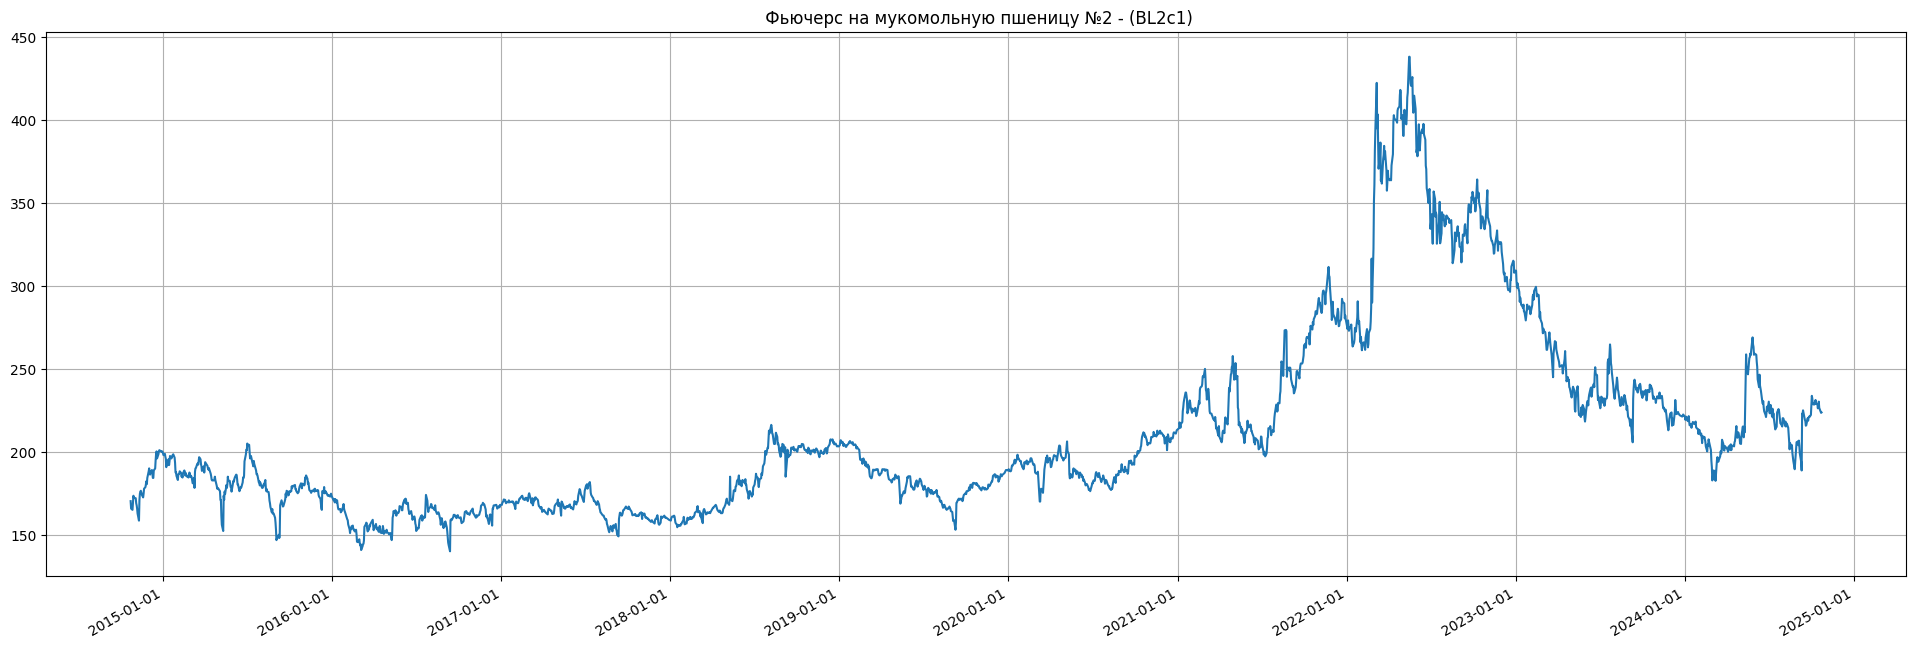

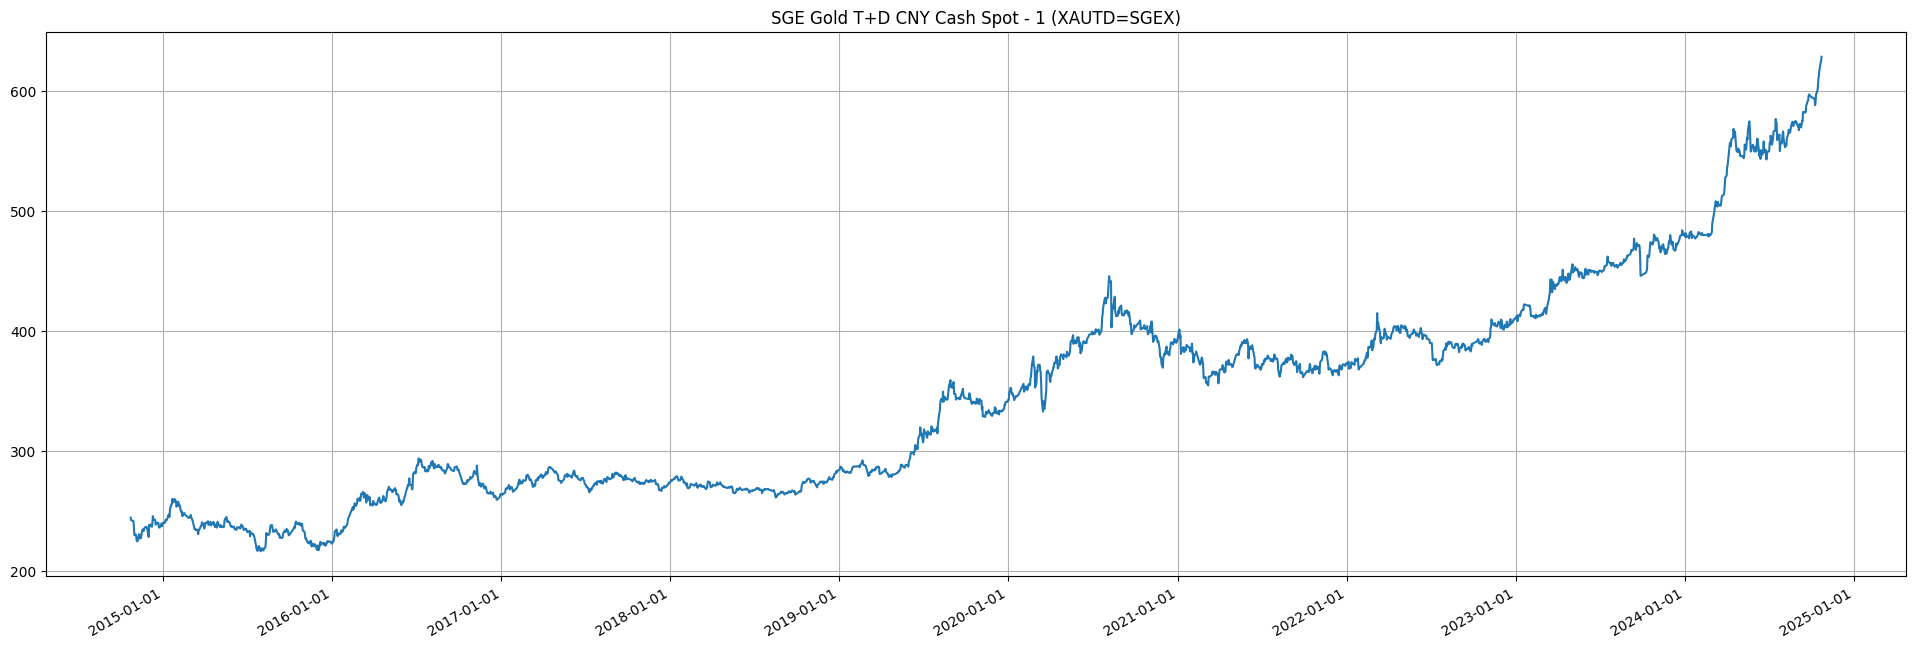

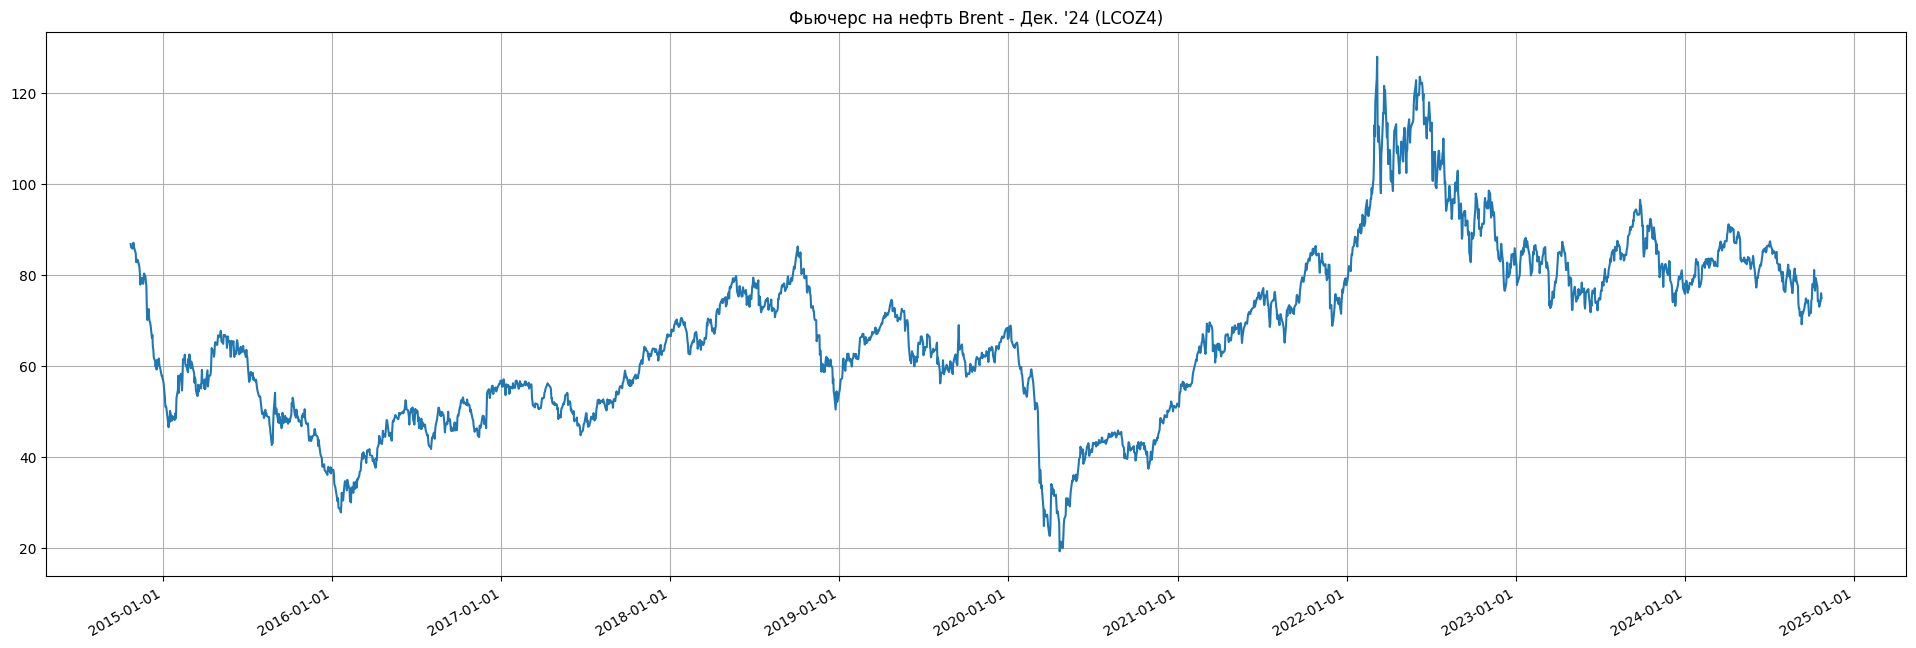

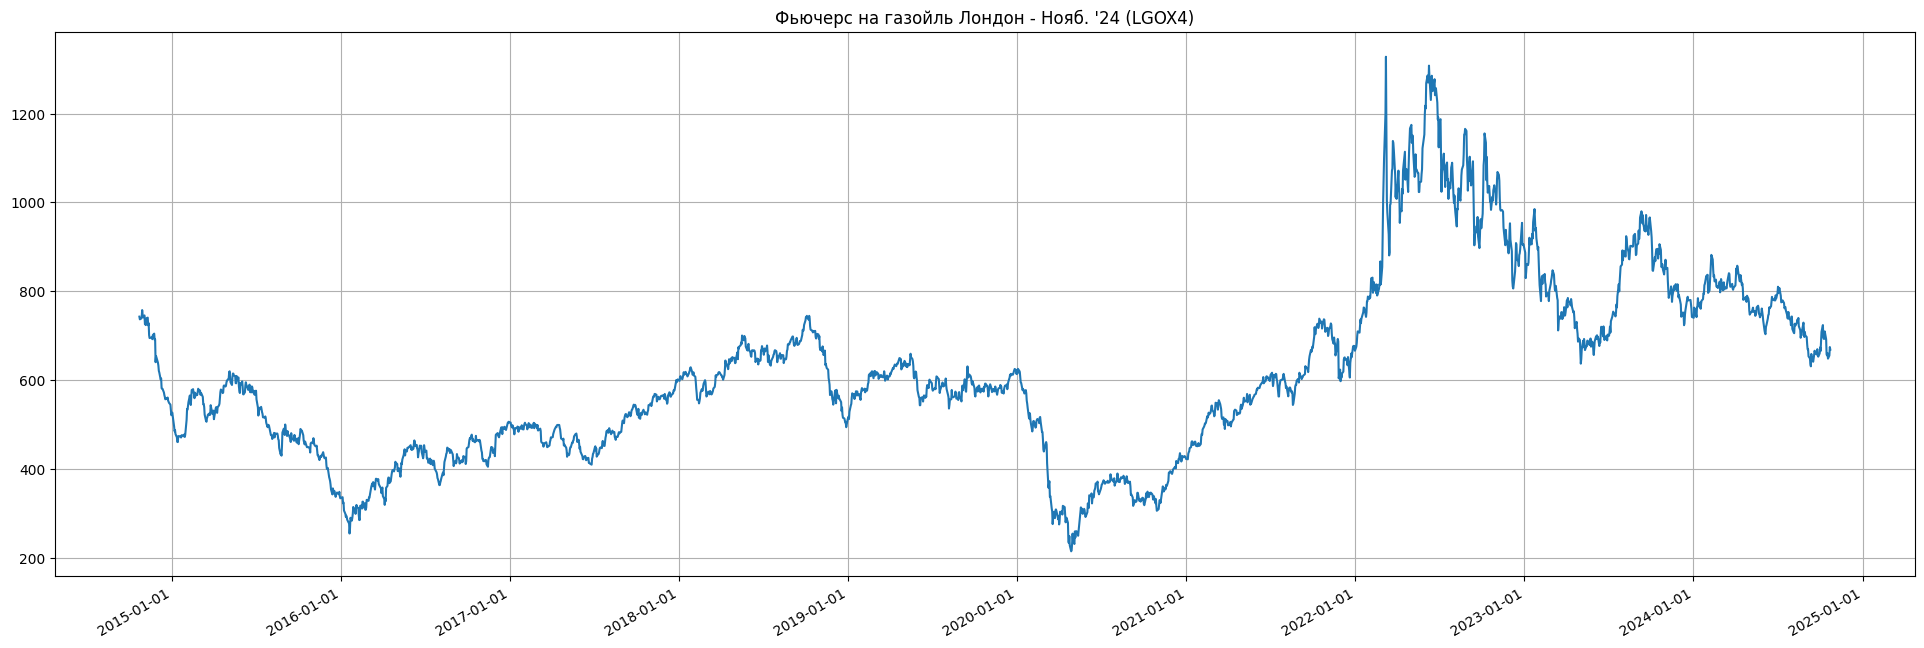

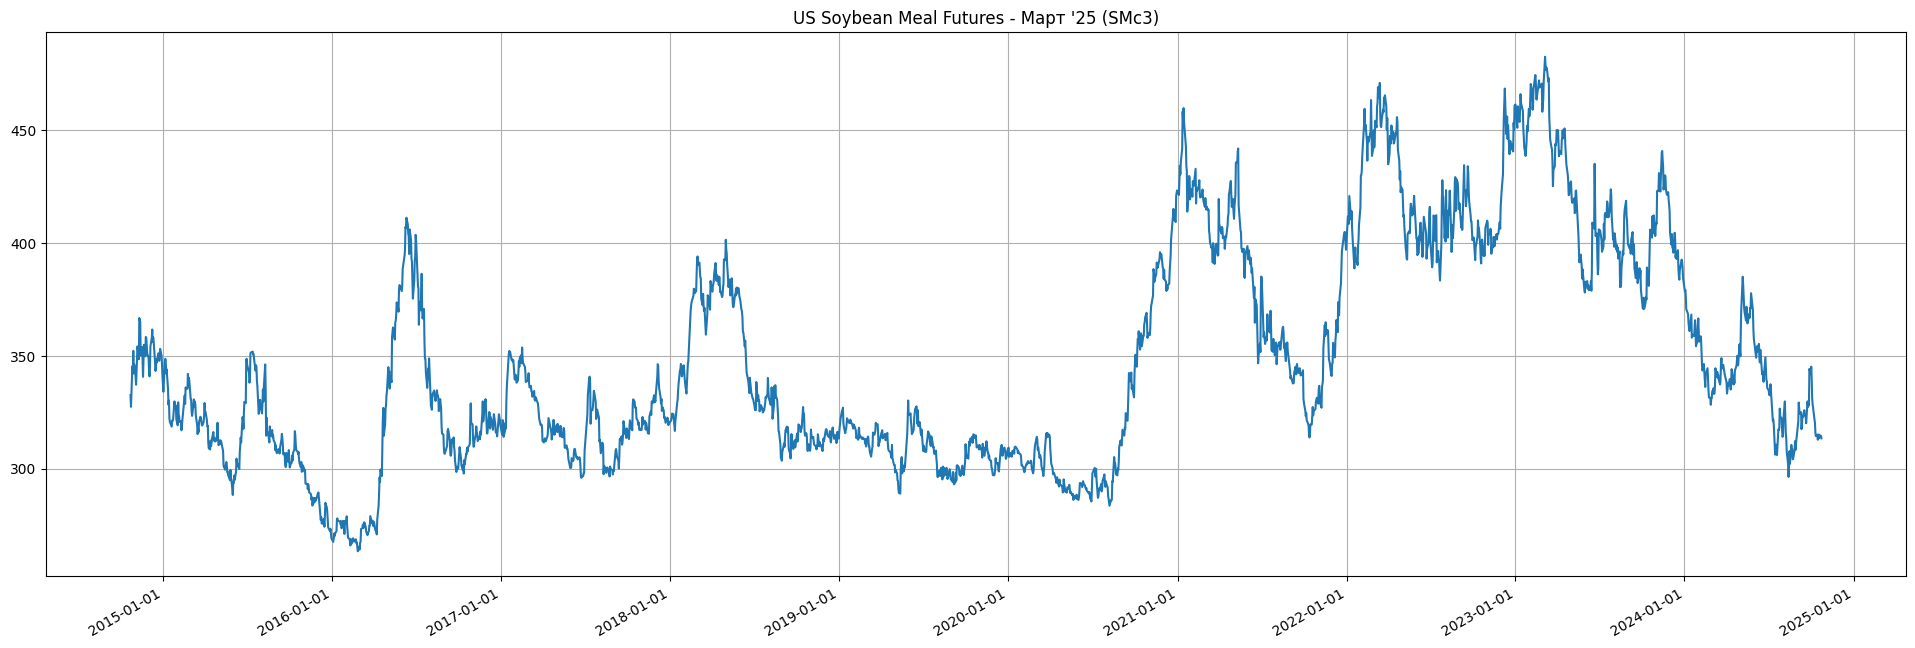

In [18]:
plot_df(df_target, df_name="target")
plot_df(df_feature_1, df_name="feature_1")
plot_df(df_feature_2, df_name="feature_2")
plot_df(df_feature_3, df_name="feature_3")
plot_df(df_feature_4, df_name="feature_4")

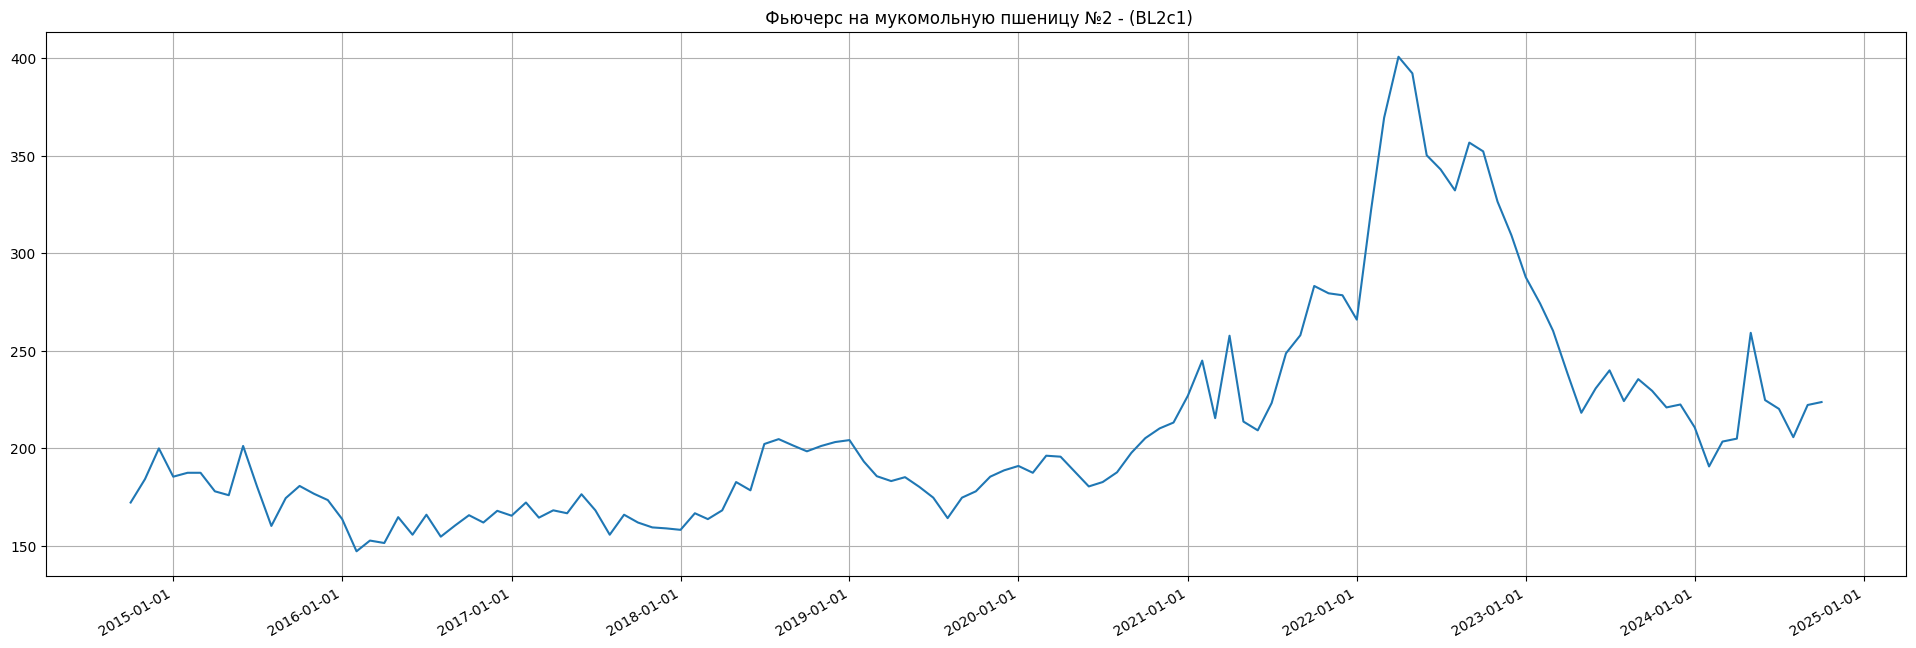

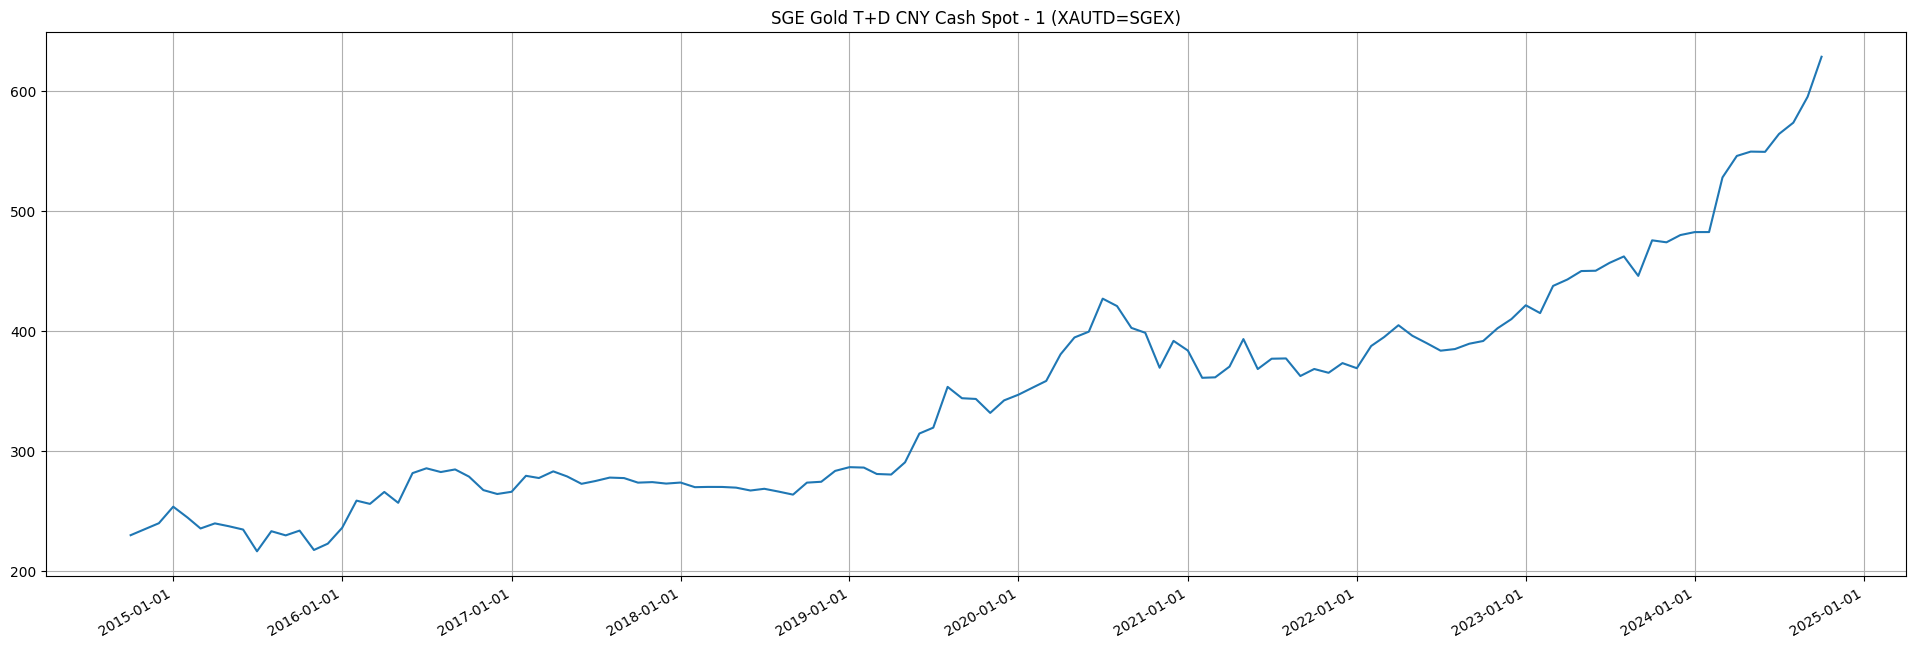

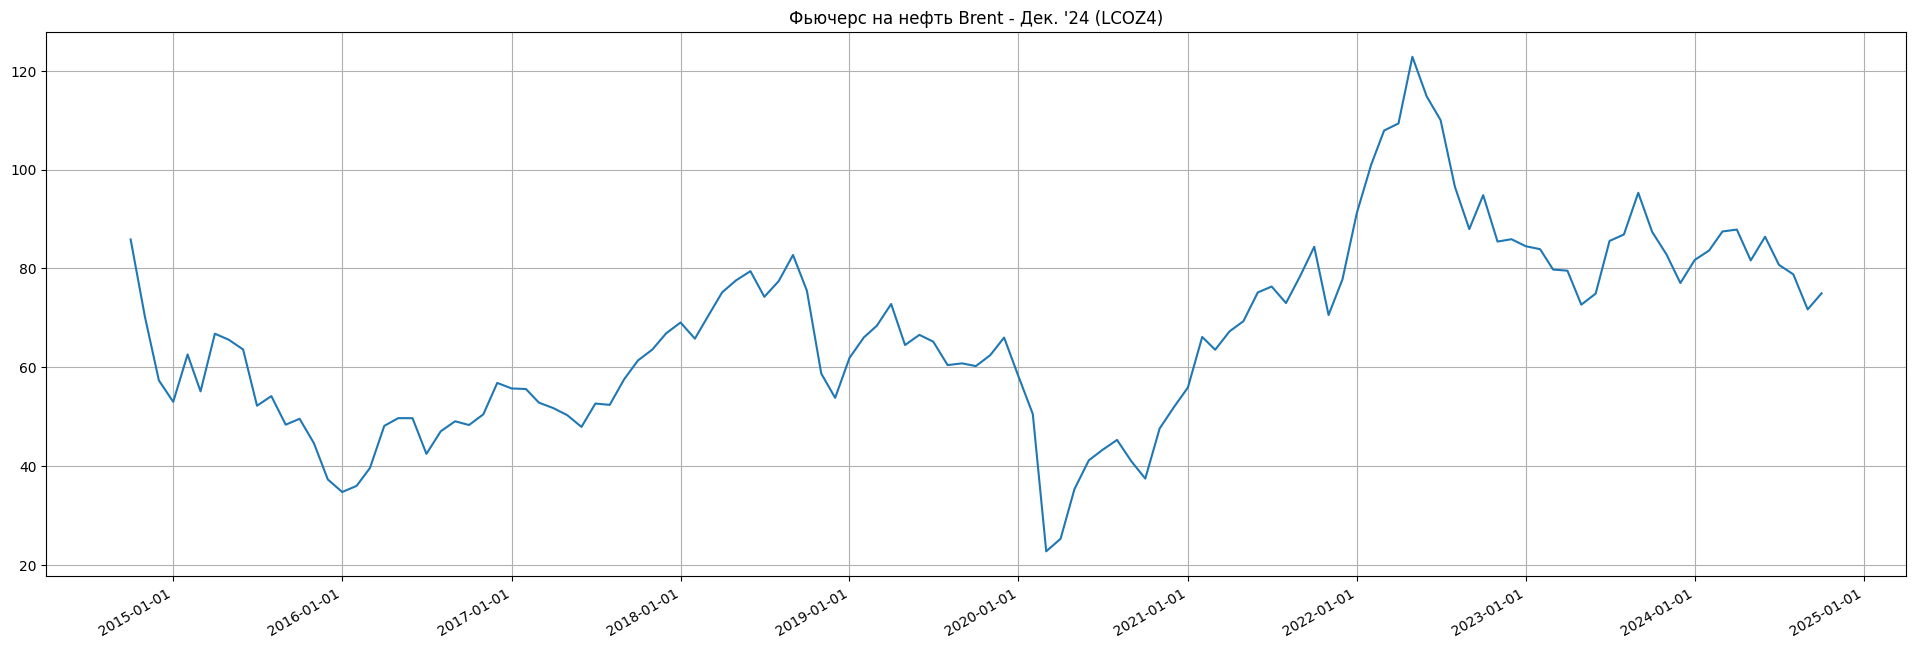

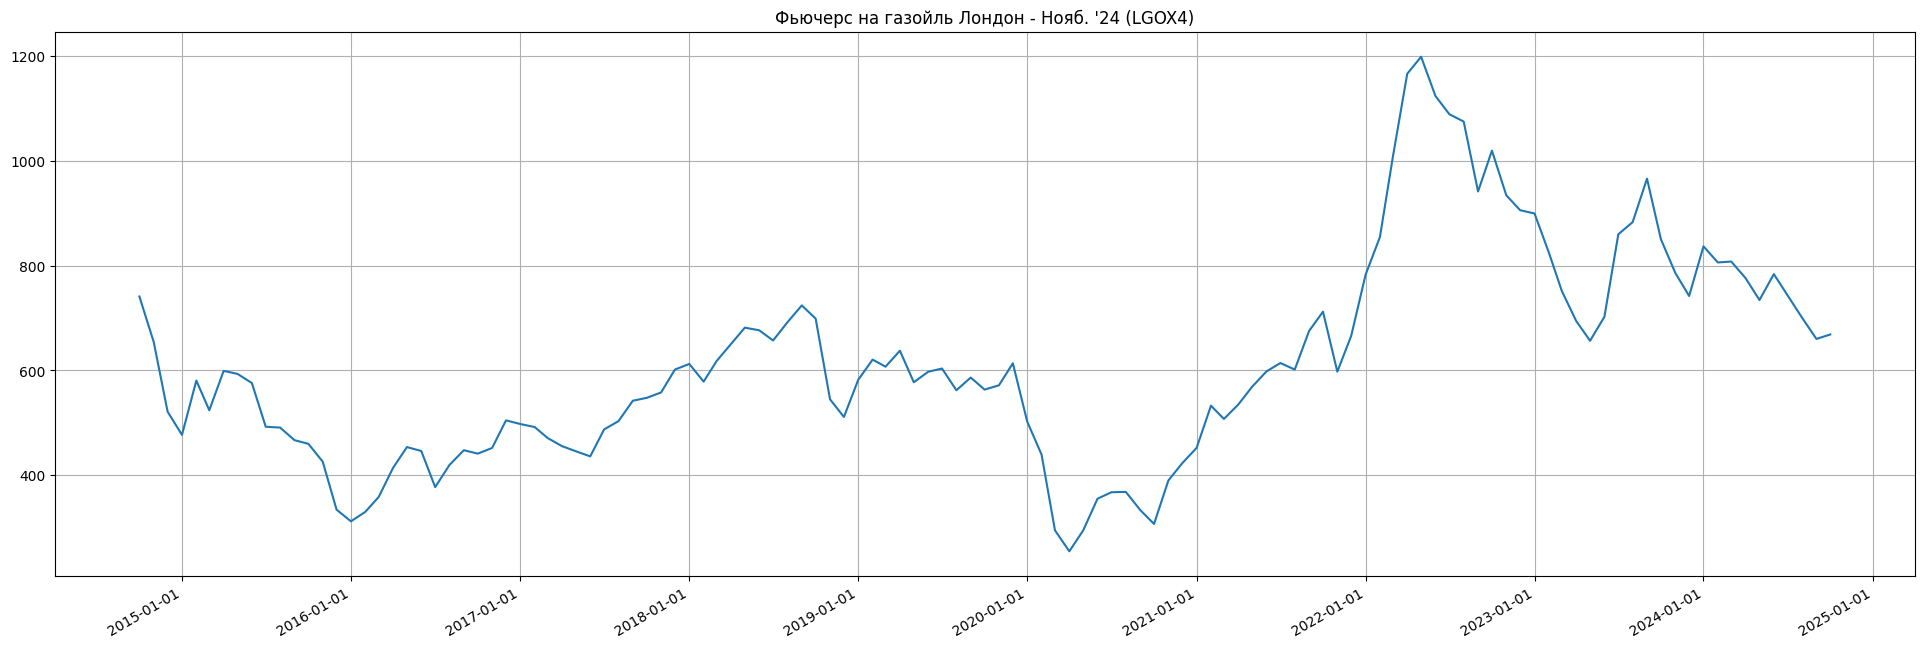

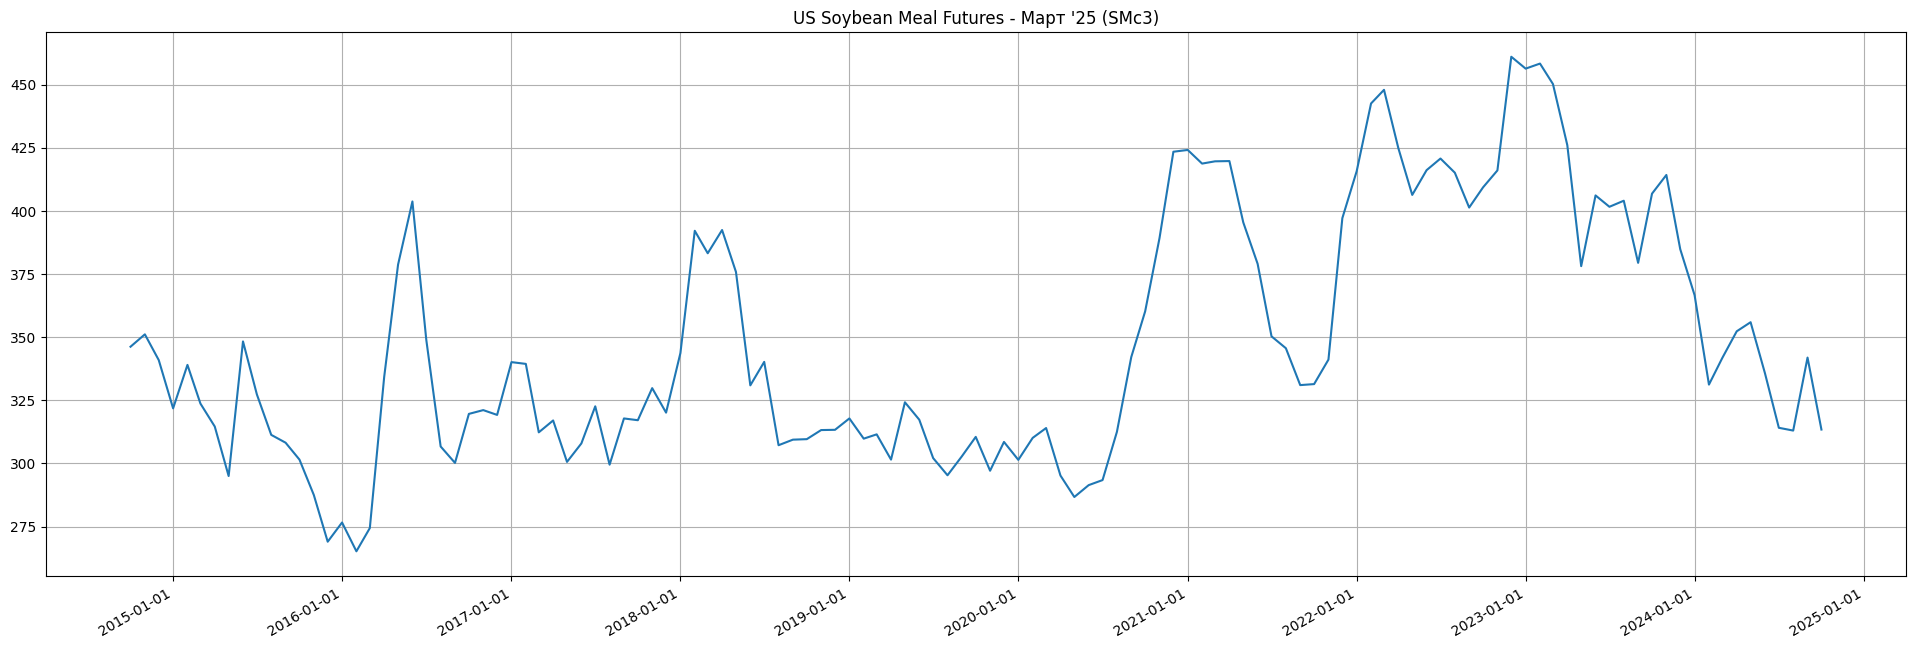

In [19]:
plot_df(df_target_monthly, df_name="target")
plot_df(df_feature_1_monthly, df_name="feature_1")
plot_df(df_feature_2_monthly, df_name="feature_2")
plot_df(df_feature_3_monthly, df_name="feature_3")
plot_df(df_feature_4_monthly, df_name="feature_4")

In [20]:
df_combined = df_target.rename(columns={"Цена": "target"})[["Дата", "target"]].copy()

df_combined = df_combined.merge(df_feature_1[["Дата", "Цена"]], on="Дата", how="left")
df_combined = df_combined.rename(columns={"Цена": "feature_1"})
df_combined = df_combined.merge(df_feature_2[["Дата", "Цена"]], on="Дата", how="left")
df_combined = df_combined.rename(columns={"Цена": "feature_2"})
df_combined = df_combined.merge(df_feature_3[["Дата", "Цена"]], on="Дата", how="left")
df_combined = df_combined.rename(columns={"Цена": "feature_3"})
df_combined = df_combined.merge(df_feature_4[["Дата", "Цена"]], on="Дата", how="left")
df_combined = df_combined.rename(columns={"Цена": "feature_4"})

df_combined = df_combined.set_index("Дата")
df_combined.head()

target  feature_1  feature_2  feature_3  feature_4
Дата                                                          
2014-10-23  170.25     244.62      86.83     743.00      332.6
2014-10-24  165.75     242.55      86.13     737.00      327.4
2014-10-27  165.00     242.10      85.83     738.75      345.4
2014-10-28  169.50     241.78      86.03     741.50      342.0
2014-10-29  173.50     241.87      87.12     757.75      352.2

{'feature_1': 'SGE Gold T+D CNY Cash Spot - 1 (XAUTD=SGEX)',
 'feature_2': "Фьючерс на нефть Brent - Дек. '24 (LCOZ4)",
 'feature_3': "Фьючерс на газойль Лондон - Нояб. '24 (LGOX4)",
 'feature_4': "US Soybean Meal Futures - Март '25 (SMc3)",
 'target': ' Фьючерс на мукомольную пшеницу №2 - (BL2c1)'}


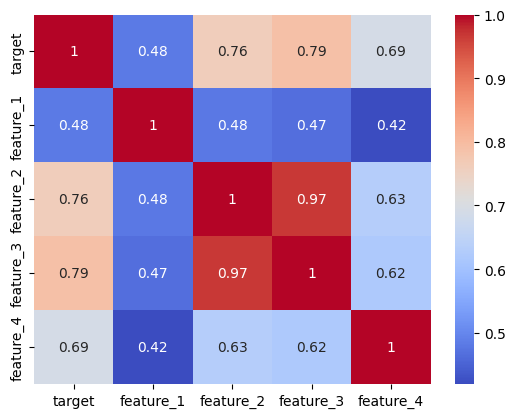

In [21]:
import seaborn as sns
from pprint import pprint

sns.heatmap(df_combined.corr(), cmap="coolwarm", annot=True)
pprint(name_decoder)

Фьючерс на пшеницу показывает достаточно сильную корелляцию со всеми остальными фичами, кроме SGE Gold

Построим графики взаимной корелляции таргета со всеми фичами и самим собой

In [22]:
def plot_cross_corr(df, col_1, col_2, name_decoder, lag_range=(0, 180)):
    lags = range(*lag_range)
    cross_corr_values = [df[col_1].shift(lag).corr(df[col_2]) for lag in lags]
    
    plt.plot(lags, cross_corr_values)
    plt.xlabel("Лаги")
    plt.ylabel("Кросс-корреляция")
    plt.title(f"Взаимная корреляция между фьючерсами\n{name_decoder[col_1]}\n и \n{name_decoder[col_2]}")
    plt.grid()
    plt.show()

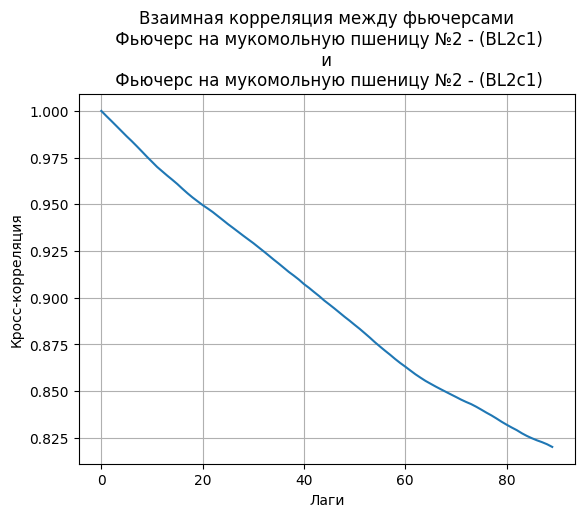

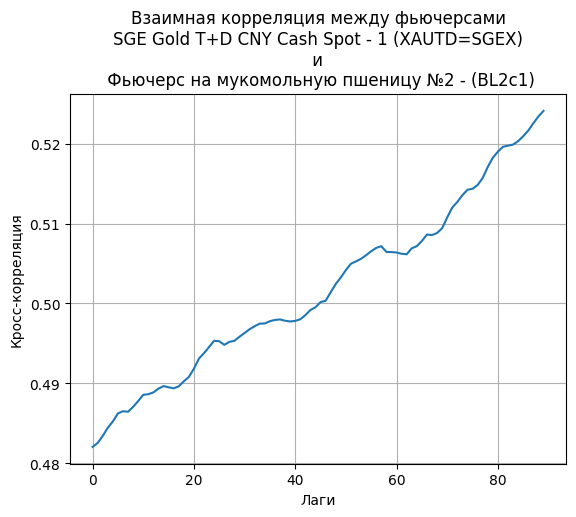

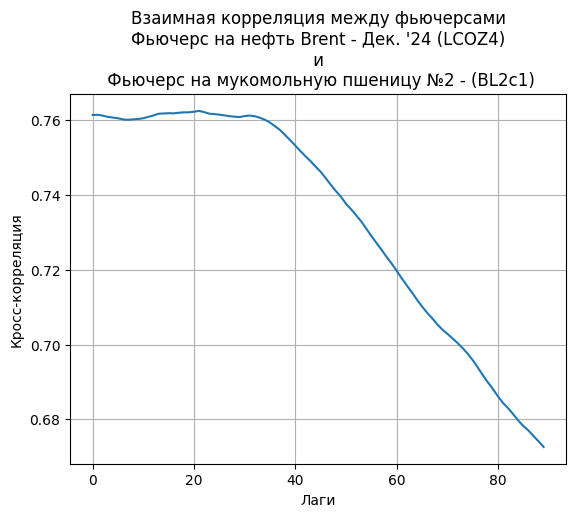

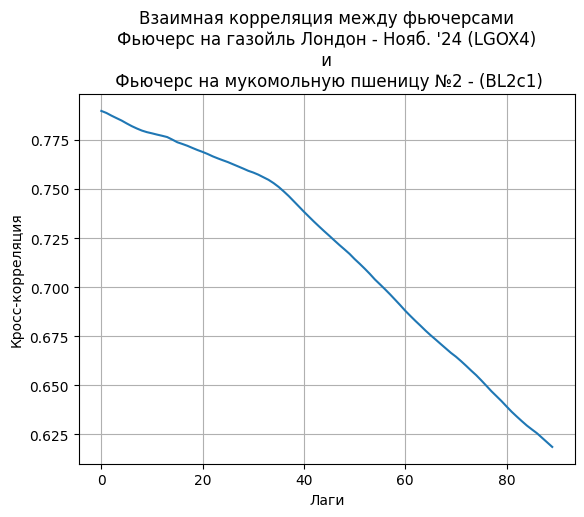

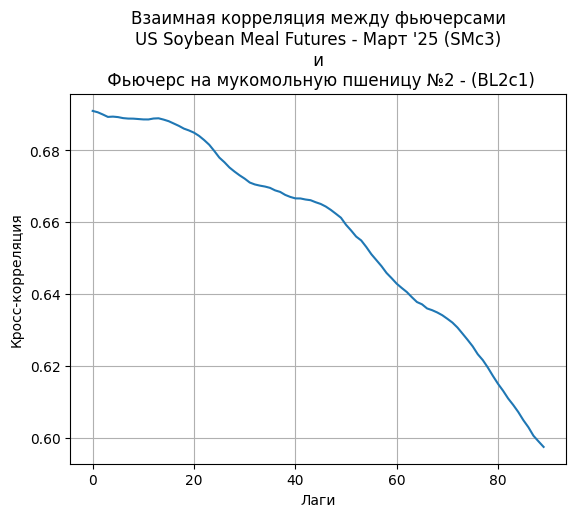

In [23]:
for f in name_decoder:
    plot_cross_corr(df_combined, f, "target", name_decoder, lag_range=(0, 90))

Также дополнительно построим графики автокорреляции и частичной автокорреляции для таргета

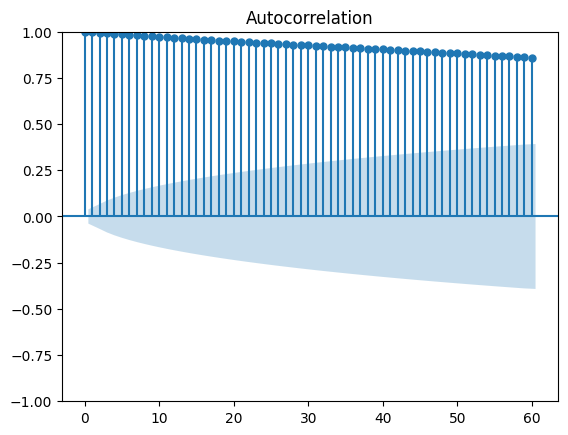

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_combined["target"], lags=60)
plt.show()

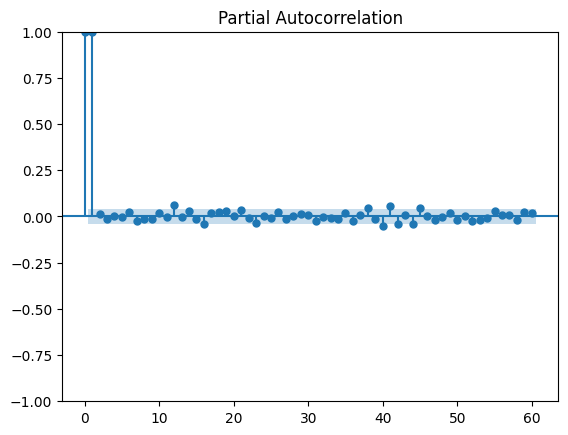

In [25]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_combined["target"], lags=60)
plt.show()

Проверка на стационарность

In [26]:
from statsmodels.tsa.stattools import adfuller, kpss


# Нулевая гипотеза (H0): временной ряд нестационарен
# p-значение < 0.05 - нулевая гипотеза отвергается (значит временной ряд стационарен)
adf_result = adfuller(df_combined["target"])
print("ADF-тест:")
print(f"ADF-статистика: {adf_result[0]}")
print(f"p-значение: {adf_result[1]}")
print("Критические значения:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")


# Нулевая гипотеза (H0): временной ряд стационарен
# p-значение < 0.05 - нулевая гипотеза отвергается (значит временной ряд нестационарен)
kpss_result = kpss(df_combined["target"], regression="c") 
print("\nKPSS-тест:")
print(f"KPSS-статистика: {kpss_result[0]}")
print(f"p-значение: {kpss_result[1]}")
print("Критические значения:")
for key, value in kpss_result[3].items():
    print(f"   {key}: {value}")

ADF-тест:
ADF-статистика: -1.9417610223287989
p-значение: 0.31267747144149605
Критические значения:
   1%: -3.4329059807036155
   5%: -2.8626692305213957
   10%: -2.5673711311351712

KPSS-тест:
KPSS-статистика: 4.260037501018911
p-значение: 0.01
Критические значения:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739


C:\Users\Nekto\AppData\Local\Temp\ipykernel_12344\1366187969.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df_combined["target"], regression="c")


Вывод: временной ряд фьючерсов на пшеницу является нестационарным, 

Также проведем тест причинности Грейнджера и тест коинтеграции с временными рядами фичей

In [27]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 30

# Нулевая гипотеза (H0): один временной ряд НЕ помогает предсказать другой (то есть лаговые значения ряда незначимы для предсказания)
# p-значение < 0.05 - нулевая гипотеза отвергается (значит временной ряд с данным лагом помогает предсказать другой)
print("Для каждого лага выводятся p-значения для следующих тестов (порядок сохранен):")
print("F test,", "chi2 test,", "likelihood ratio test,", "parameter F test")
for f in list(name_decoder.keys())[1:]:
    granger_test = grangercausalitytests(df_combined[["target", f]].dropna(), maxlag=maxlag, verbose=False)
    print(name_decoder[f])
    for lag in granger_test.keys():
        print("Лаг:", lag, 
              f"{round(granger_test[lag][0]["ssr_ftest"][1], 4)},",
              f"{round(granger_test[lag][0]["ssr_chi2test"][1], 4)},",
              f"{round(granger_test[lag][0]["lrtest"][1], 4)},",
              f"{round(granger_test[lag][0]["params_ftest"][1], 4)}")

Для каждого лага выводятся p-значения для следующих тестов (порядок сохранен):
F test, chi2 test, likelihood ratio test, parameter F test


C:\Users\Nekto\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


SGE Gold T+D CNY Cash Spot - 1 (XAUTD=SGEX)
Лаг: 1 0.3487, 0.3483, 0.3484, 0.3487
Лаг: 2 0.6522, 0.6516, 0.6516, 0.6522
Лаг: 3 0.3737, 0.3721, 0.3724, 0.3737
Лаг: 4 0.3218, 0.3195, 0.32, 0.3218
Лаг: 5 0.4566, 0.4536, 0.4542, 0.4566
Лаг: 6 0.4775, 0.4737, 0.4745, 0.4775
Лаг: 7 0.5132, 0.5085, 0.5094, 0.5132
Лаг: 8 0.5935, 0.5883, 0.5893, 0.5935
Лаг: 9 0.6328, 0.6269, 0.628, 0.6328
Лаг: 10 0.6539, 0.6472, 0.6485, 0.6539
Лаг: 11 0.7399, 0.7335, 0.7347, 0.7399
Лаг: 12 0.5926, 0.583, 0.585, 0.5926
Лаг: 13 0.5723, 0.5613, 0.5636, 0.5723
Лаг: 14 0.4707, 0.4575, 0.4606, 0.4707
Лаг: 15 0.4792, 0.4648, 0.4681, 0.4792
Лаг: 16 0.5486, 0.5333, 0.5367, 0.5486
Лаг: 17 0.5111, 0.4939, 0.4979, 0.5111
Лаг: 18 0.5493, 0.531, 0.5351, 0.5493
Лаг: 19 0.4249, 0.4042, 0.4093, 0.4249
Лаг: 20 0.4829, 0.4607, 0.4659, 0.4829
Лаг: 21 0.5047, 0.4811, 0.4866, 0.5047
Лаг: 22 0.4647, 0.4391, 0.4452, 0.4647
Лаг: 23 0.4752, 0.4479, 0.4544, 0.4752
Лаг: 24 0.4697, 0.4406, 0.4476, 0.4697
Лаг: 25 0.5133, 0.4827, 0.4899, 0.5

C:\Users\Nekto\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Фьючерс на нефть Brent - Дек. '24 (LCOZ4)
Лаг: 1 0.0241, 0.024, 0.024, 0.0241
Лаг: 2 0.0039, 0.0038, 0.0038, 0.0039
Лаг: 3 0.0085, 0.0083, 0.0084, 0.0085
Лаг: 4 0.0094, 0.009, 0.0092, 0.0094
Лаг: 5 0.0189, 0.0182, 0.0185, 0.0189
Лаг: 6 0.0256, 0.0246, 0.025, 0.0256
Лаг: 7 0.0111, 0.0105, 0.0108, 0.0111
Лаг: 8 0.0077, 0.0071, 0.0074, 0.0077
Лаг: 9 0.0114, 0.0105, 0.0109, 0.0114
Лаг: 10 0.016, 0.0147, 0.0152, 0.016
Лаг: 11 0.0132, 0.012, 0.0125, 0.0132
Лаг: 12 0.0194, 0.0176, 0.0182, 0.0194
Лаг: 13 0.0253, 0.0229, 0.0238, 0.0253
Лаг: 14 0.0171, 0.0151, 0.0158, 0.0171
Лаг: 15 0.0257, 0.0228, 0.0238, 0.0257
Лаг: 16 0.0352, 0.0312, 0.0326, 0.0352
Лаг: 17 0.0258, 0.0224, 0.0236, 0.0258
Лаг: 18 0.0308, 0.0266, 0.028, 0.0308
Лаг: 19 0.042, 0.0364, 0.0382, 0.042
Лаг: 20 0.0371, 0.0316, 0.0334, 0.0371
Лаг: 21 0.0615, 0.0531, 0.0557, 0.0615
Лаг: 22 0.0027, 0.002, 0.0023, 0.0027
Лаг: 23 0.0039, 0.0029, 0.0033, 0.0039
Лаг: 24 0.001, 0.0007, 0.0008, 0.001
Лаг: 25 0.0013, 0.0009, 0.0011, 0.0013
Лаг: 

C:\Users\Nekto\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Фьючерс на газойль Лондон - Нояб. '24 (LGOX4)
Лаг: 1 0.2017, 0.2014, 0.2014, 0.2017
Лаг: 2 0.0014, 0.0014, 0.0014, 0.0014
Лаг: 3 0.002, 0.002, 0.002, 0.002
Лаг: 4 0.0053, 0.0051, 0.0052, 0.0053
Лаг: 5 0.0044, 0.0041, 0.0042, 0.0044
Лаг: 6 0.0099, 0.0094, 0.0097, 0.0099
Лаг: 7 0.01, 0.0094, 0.0096, 0.01
Лаг: 8 0.0117, 0.0109, 0.0112, 0.0117
Лаг: 9 0.0023, 0.0021, 0.0022, 0.0023
Лаг: 10 0.0017, 0.0015, 0.0015, 0.0017
Лаг: 11 0.0021, 0.0018, 0.0019, 0.0021
Лаг: 12 0.0073, 0.0065, 0.0068, 0.0073
Лаг: 13 0.0087, 0.0077, 0.0081, 0.0087
Лаг: 14 0.0, 0.0, 0.0, 0.0
Лаг: 15 0.0, 0.0, 0.0, 0.0
Лаг: 16 0.0, 0.0, 0.0, 0.0
Лаг: 17 0.0, 0.0, 0.0, 0.0
Лаг: 18 0.0, 0.0, 0.0, 0.0
Лаг: 19 0.0, 0.0, 0.0, 0.0
Лаг: 20 0.0, 0.0, 0.0, 0.0
Лаг: 21 0.0, 0.0, 0.0, 0.0
Лаг: 22 0.0, 0.0, 0.0, 0.0
Лаг: 23 0.0, 0.0, 0.0, 0.0
Лаг: 24 0.0, 0.0, 0.0, 0.0
Лаг: 25 0.0, 0.0, 0.0, 0.0
Лаг: 26 0.0, 0.0, 0.0, 0.0
Лаг: 27 0.0, 0.0, 0.0, 0.0
Лаг: 28 0.0, 0.0, 0.0, 0.0
Лаг: 29 0.0, 0.0, 0.0, 0.0
Лаг: 30 0.0, 0.0, 0.0, 0.0


C:\Users\Nekto\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


US Soybean Meal Futures - Март '25 (SMc3)
Лаг: 1 0.1307, 0.1303, 0.1304, 0.1307
Лаг: 2 0.0485, 0.048, 0.0482, 0.0485
Лаг: 3 0.048, 0.0473, 0.0475, 0.048
Лаг: 4 0.077, 0.0757, 0.0762, 0.077
Лаг: 5 0.0736, 0.072, 0.0726, 0.0736
Лаг: 6 0.1242, 0.1215, 0.1223, 0.1242
Лаг: 7 0.1345, 0.1311, 0.1321, 0.1345
Лаг: 8 0.185, 0.1803, 0.1816, 0.185
Лаг: 9 0.2507, 0.2445, 0.2462, 0.2507
Лаг: 10 0.2833, 0.2758, 0.2778, 0.2833
Лаг: 11 0.2826, 0.2741, 0.2763, 0.2826
Лаг: 12 0.1497, 0.1424, 0.1446, 0.1497
Лаг: 13 0.2181, 0.2084, 0.2111, 0.2181
Лаг: 14 0.2559, 0.2445, 0.2476, 0.2559
Лаг: 15 0.0821, 0.0753, 0.0774, 0.0821
Лаг: 16 0.1046, 0.0959, 0.0986, 0.1046
Лаг: 17 0.1352, 0.1242, 0.1275, 0.1352
Лаг: 18 0.1609, 0.1479, 0.1516, 0.1609
Лаг: 19 0.1964, 0.1808, 0.1851, 0.1964
Лаг: 20 0.1054, 0.0937, 0.0972, 0.1054
Лаг: 21 0.011, 0.0088, 0.0095, 0.011
Лаг: 22 0.0105, 0.0082, 0.009, 0.0105
Лаг: 23 0.01, 0.0076, 0.0084, 0.01
Лаг: 24 0.011, 0.0083, 0.0092, 0.011
Лаг: 25 0.0166, 0.0127, 0.0139, 0.0166
Лаг: 26 0

In [28]:
from statsmodels.tsa.stattools import coint

# Нулевая гипотеза (H0): один временной ряд НЕ коинтегрирован с другим
# p-значение < 0.05 - нулевая гипотеза отвергается (значит временной ряд коинтегрирован с другим)
for f in list(name_decoder.keys())[1:]:
    print(name_decoder[f])
    df_test = df_combined[["target", f]].dropna().copy()
    score, p_value, _ = coint(df_test["target"], df_test[f])
    print("Коинтеграционный тест, p-значение:", round(p_value, 4))
    print()

SGE Gold T+D CNY Cash Spot - 1 (XAUTD=SGEX)
Коинтеграционный тест, p-значение: 0.5679

Фьючерс на нефть Brent - Дек. '24 (LCOZ4)
Коинтеграционный тест, p-значение: 0.0106

Фьючерс на газойль Лондон - Нояб. '24 (LGOX4)
Коинтеграционный тест, p-значение: 0.024

US Soybean Meal Futures - Март '25 (SMc3)
Коинтеграционный тест, p-значение: 0.0605



Исследование сезонности

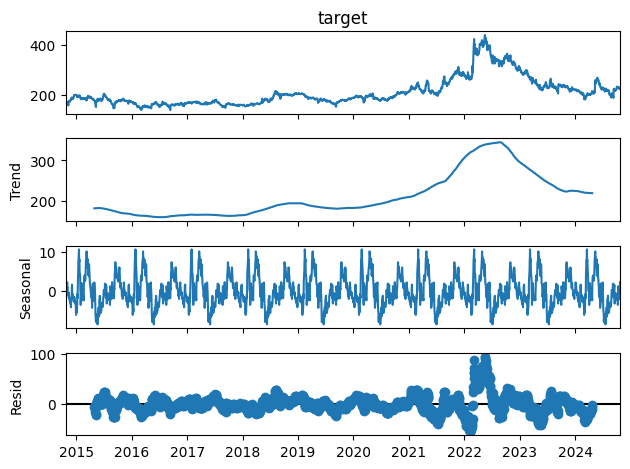

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose


period = 261  # период взят за 261, чтобы учесть, что в данных нет выходных дней, но при этом проанализировать годовой период

decomposition = seasonal_decompose(df_combined["target"], model="additive", period=period)
decomposition.plot()
plt.show()

## Выводы:

Временной ряд "Фьючерс на мукомольную пшеницу №2" является нестационарным временным рядом с трендом на повышение. Ряд имеет выраженный пик в 2022 году, связанный с геополитическими событиями, но с тех пор он выравнивается и стабилизурется, хоть и со скачками.

По графику временного ряда, как в разрезе дней, так и в разрезе месяцев, можно судить о наличии сезонности: обычно имеется резкий скачок цены вверх в первой половине года и резкий скачок вниз во второй. Это можно объяснить тем, что при приближении зимы повышается спрос на посевные, а на лето приходится период урожая.

Корреляционный анализ показывает, что фьючерс на мукомольную пшеницу имеет ярко выраженную корреляцию с "Фьючерс на нефть Brent", "Фьючерс на газойль Лондон" и "US Soybean Meal Futures", корреляция с "SGE Gold" не так сильно выражена. Также можно заметить, что фьючерс на нефть Brent и фьючерс на газойль Лондон сильно коррелируют между собой.

На графиках взаимной корреляции с фичами можно увидеть, что с ростом окна лага растет и корреляция с фьючерсом SGE Gold, хотя она все равно остается достаточно низкой. Взаимная корреляция с фьючерс на нефть Brent стабильно высокая вплоть до лага на ~37 дней, где она начинает резко падать. В случае фьючерса на газойль Лондон, падение начинается сразу с первого лага. Похожая картина наблюдается и с фьючерсом на US Soybean Meal, хотя падение менее гладкое.

Анализ автокорреляции и частичной автокорреляции фьючерс на мукомольную пшеницу показывает, что этот временной ряд представляет авторегрессионную модель первого порядка AR(1), так как только первый лаг имеет высокое значение в случае частичной автокорреляци, а в ином случае величина корреляции убывает с увеличением лага. 

Тесты на стационарность подтверждают, что временной не является стационарным.

Из результатов теста причинности Грейнджера можно сделать вывод, что фьючерс SGE Gold имеет слабую предсказательную способность для предсказания фьючерса на мукомольную пшеницу вне зависимости от окна лага. Фьючерс на нефть Brent имеет хорошую предсказательную способность, особенно на лагах 2-4, 8, 22-30. Фьючерс на газойль Лондон имеет хорошую предсказательную способность, особенно на лагах 2-6, 10-13. Фьючерс на US Soybean Meal также имеет хорошую предсказательную способность на лагах 21-30.

Коинтеграционный тест показывает, что фьючерс на мукомольную пшеницу коинтегрирован с фьючерсом на нефть Brent и фьючерсом на газойль Лондон, то есть между этими рядами присутствует долгосрочная связь. P-значение теста с фьючерсом на US Soybean Meal не дает основание предполагать наличие коинтегрированности этих двух временных рядов.

График сезонности при декомпозиции временного ряда подвертждает наличие сезонности в данных.

# Обучение моделей

## Модель Prophet

Воспользуемся моделью Prophet для получения предсказаний временного ряда

In [30]:
df_target = pd.read_csv("target.csv")
df_target = df_transform(df_target, fill_date_gaps=False)

train_test_split_days = 90  # Сколько дней выделить на тестовый набор

df = df_target.rename(columns={"Дата": "ds", "Цена": "y"})[["ds", "y"]].copy()
df_train = df.iloc[:-train_test_split_days].copy()
df_test = df.iloc[-train_test_split_days:].copy()

display(df_train.tail())
display(df_test.head())

ds       y
2467 2024-06-13  238.50
2468 2024-06-14  236.75
2469 2024-06-17  230.25
2470 2024-06-18  229.00
2471 2024-06-19  230.50

ds       y
2472 2024-06-20  226.75
2473 2024-06-21  224.50
2474 2024-06-24  222.25
2475 2024-06-25  221.00
2476 2024-06-26  223.50

05:07:14 - cmdstanpy - INFO - Chain [1] start processing
05:07:15 - cmdstanpy - INFO - Chain [1] done processing


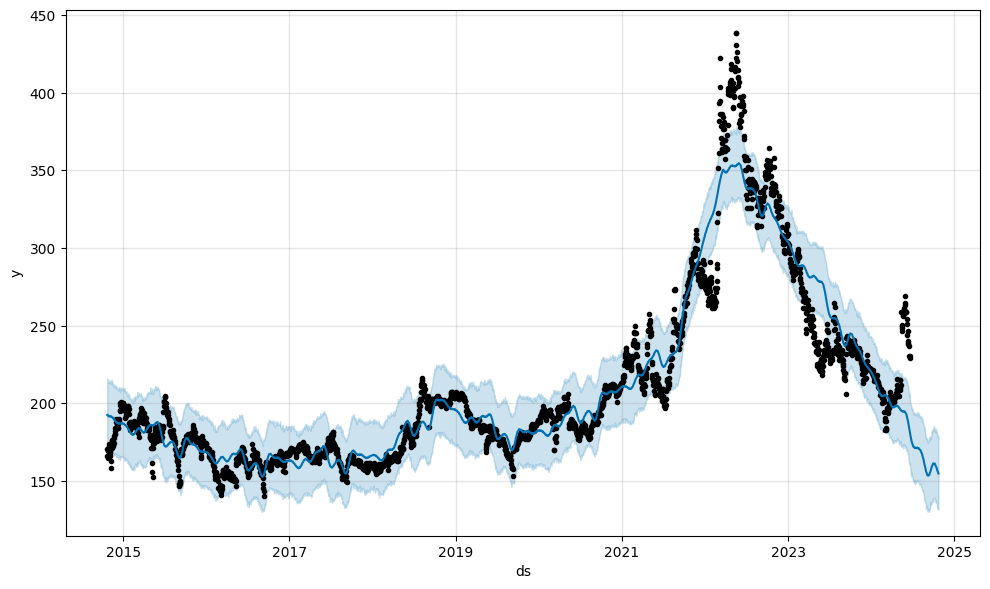

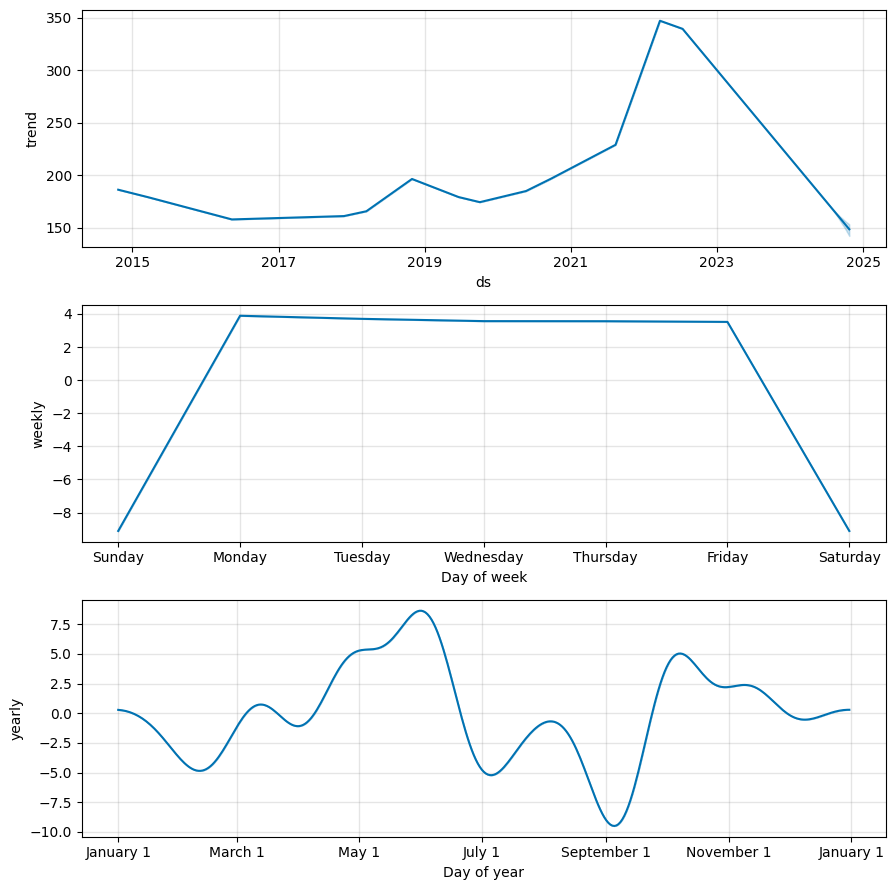

In [31]:
from prophet import Prophet
from prophet.plot import plot, plot_components

model = Prophet()
model.fit(df_train) 

future = pd.concat([df_train[["ds"]], df_test[["ds"]]], ignore_index=True)
forecast = model.predict(future)  

plot(model, forecast)
plot_components(model, forecast)
plt.show()

Оценки модели

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def score_model(actual_values, predictions):
    mae = mean_absolute_error(actual_values, predictions)
    mse = mean_squared_error(actual_values, predictions)
    rmse = mse ** 0.5
    mape = mean_absolute_percentage_error(actual_values, predictions)
    
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape * 100:.2f}%")

In [33]:
predictions = forecast[["ds", "yhat"]]
predictions_test = forecast[["ds", "yhat"]].iloc[-train_test_split_days:]

print("Оценки на полном датасете:")
score_model(df["y"].values, predictions["yhat"].values)
print()

print("Оценки только на тестовой части:")
score_model(df_test["y"].values, predictions_test["yhat"].values)

Оценки на полном датасете:
MAE: 12.87
MSE: 388.06
RMSE: 19.70
MAPE: 5.78%

Оценки только на тестовой части:
MAE: 53.26
MSE: 2958.16
RMSE: 54.39
MAPE: 24.35%


Оценки на тестовой части не слишком впечатляют, но стоит учитывать, что для обучения использовались все 10 лет данных, включая значительный скачок в начале 2022 года

Обучим модель только на последних трех годах и посмотрим на оценки

In [34]:
df_target = pd.read_csv("target.csv")
df_target = df_transform(df_target, fill_date_gaps=False, df_start_date="23.10.21")

train_test_split_days = 90  # Сколько дней выделить на тестовый набор

df = df_target.rename(columns={"Дата": "ds", "Цена": "y"})[["ds", "y"]].copy()
df_train = df.iloc[:-train_test_split_days].copy()
df_test = df.iloc[-train_test_split_days:].copy()

display(df_train.tail())
display(df_test.head())

ds       y
676 2024-06-13  238.50
677 2024-06-14  236.75
678 2024-06-17  230.25
679 2024-06-18  229.00
680 2024-06-19  230.50

ds       y
681 2024-06-20  226.75
682 2024-06-21  224.50
683 2024-06-24  222.25
684 2024-06-25  221.00
685 2024-06-26  223.50

05:07:18 - cmdstanpy - INFO - Chain [1] start processing
05:07:18 - cmdstanpy - INFO - Chain [1] done processing


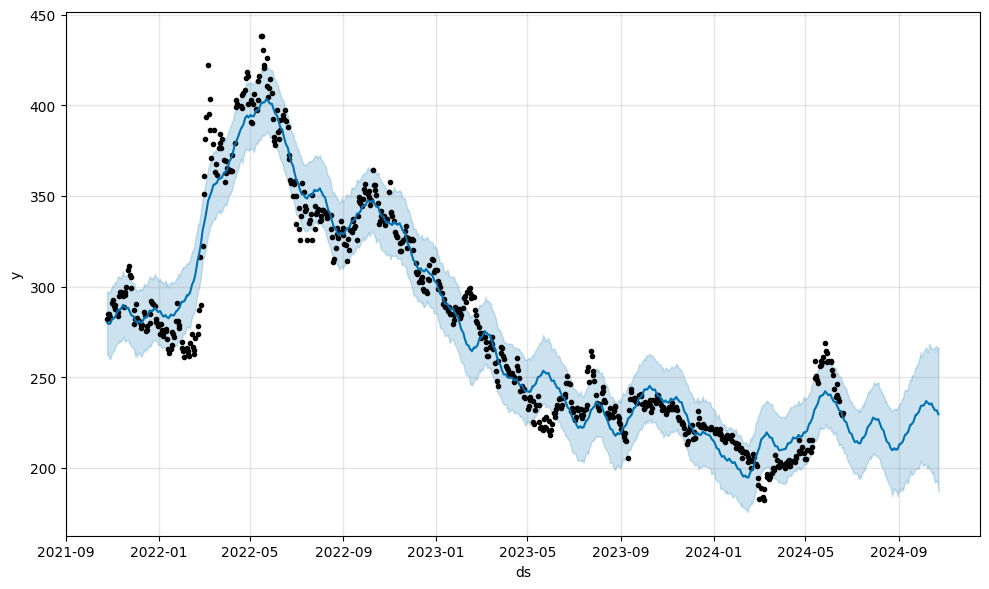

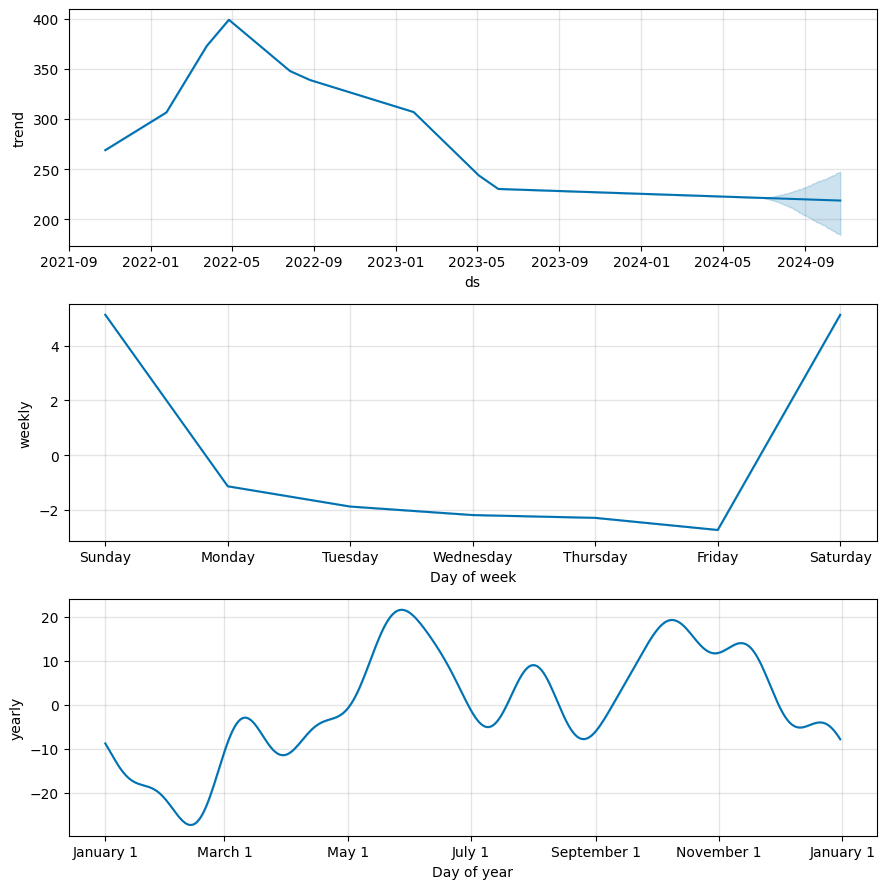

In [35]:
model = Prophet()
model.fit(df_train) 

future = pd.concat([df_train[["ds"]], df_test[["ds"]]], ignore_index=True)
forecast = model.predict(future)  

plot(model, forecast)
plot_components(model, forecast)
plt.show()

In [36]:
predictions = forecast[["ds", "yhat"]]
predictions_test = forecast[["ds", "yhat"]].iloc[-train_test_split_days:]

print("Оценки на полном датасете:")
score_model(df["y"].values, predictions["yhat"].values)
print()

print("Оценки только на тестовой части:")
score_model(df_test["y"].values, predictions_test["yhat"].values)

Оценки на полном датасете:
MAE: 10.37
MSE: 187.00
RMSE: 13.67
MAPE: 3.95%

Оценки только на тестовой части:
MAE: 7.86
MSE: 85.13
RMSE: 9.23
MAPE: 3.70%


Оценка значительно улучшилась, шум в данных в прошлом явно очень плохо сказывался на предсказаниях в настоящем

Посмотрим, как модель справляется с предсказанием других временных рядов. Обучать будем как и на всем наборе данных, так и только на последних трех годах

Возможно, можно использовать предсказания других рядов как регрессоры для дальнейшего улучшения предсказания фьючерсов на пшеницу

In [37]:
def pipeline(table_name, df_start_date=None,
             plot_prophet=True, print_scores=True, 
             train_test_split_days=90, future_only=False, 
             datecol_name="Дата", target_name="Цена"):
    df = pd.read_csv(f"{table_name}.csv")
    if df_start_date:
        df = df_transform(df, fill_date_gaps=False, df_start_date=df_start_date)
    else:
        df = df_transform(df, fill_date_gaps=False)
    df = df.rename(columns={"Дата": "ds", "Цена": "y"})[["ds", "y"]].copy()
    
    df_train = df.iloc[:-train_test_split_days].copy()
    df_test = df.iloc[-train_test_split_days:].copy()

    model = Prophet()
    model.fit(df_train)

    if future_only:
        future = df_test[["ds"]]
    else:
        future = pd.concat([df_train[["ds"]], df_test[["ds"]]], ignore_index=True)
    forecast = model.predict(future)

    if plot_prophet:
        plot(model, forecast)
        plot_components(model, forecast)
        plt.show()

    if print_scores:
        predictions = forecast[["ds", "yhat"]]
        predictions_test = forecast[["ds", "yhat"]].iloc[-train_test_split_days:]
        
        print("Оценки на полном датасете:")
        score_model(df["y"].values, predictions["yhat"].values)
        print()
        
        print("Оценки только на тестовой части:")
        score_model(df_test["y"].values, predictions_test["yhat"].values)
    
    return forecast

05:07:19 - cmdstanpy - INFO - Chain [1] start processing
05:07:20 - cmdstanpy - INFO - Chain [1] done processing


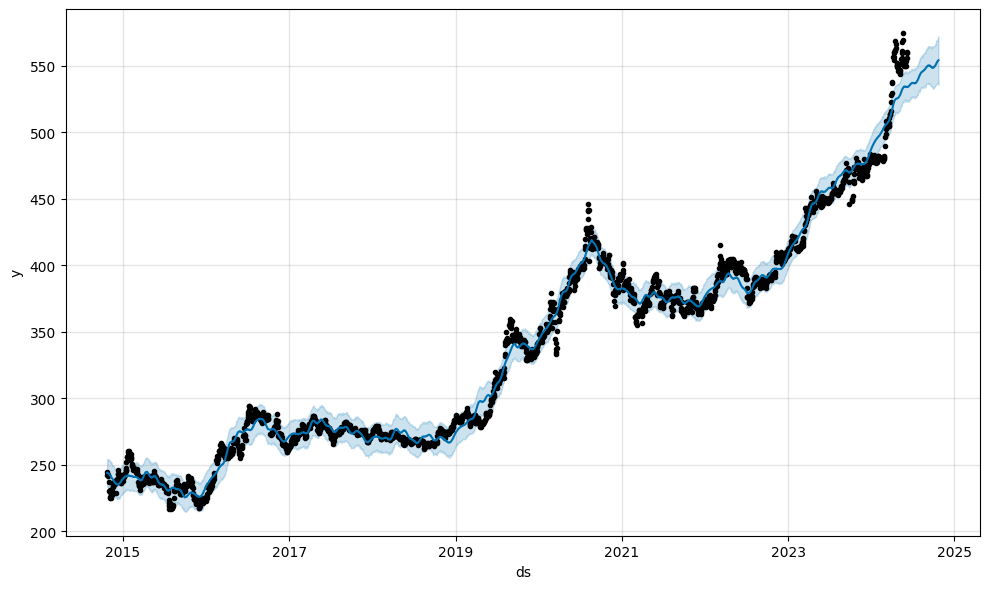

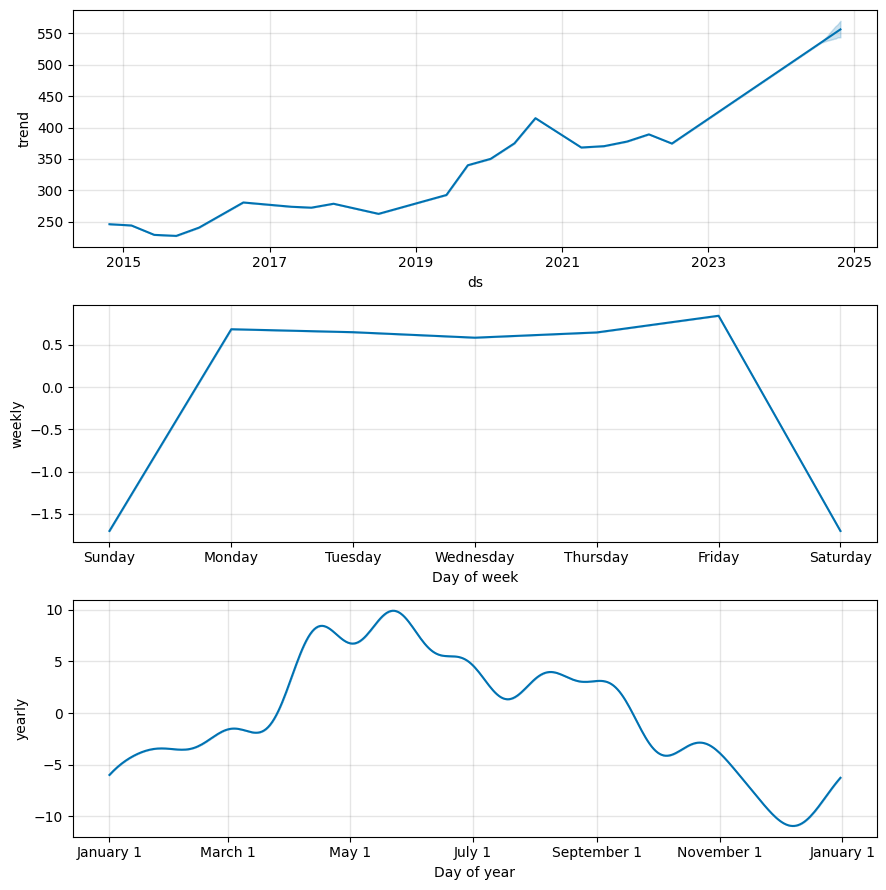

Оценки на полном датасете:
MAE: 6.91
MSE: 101.10
RMSE: 10.05
MAPE: 1.94%

Оценки только на тестовой части:
MAE: 27.04
MSE: 955.99
RMSE: 30.92
MAPE: 4.66%


In [38]:
pred = pipeline("feature_1")

05:07:22 - cmdstanpy - INFO - Chain [1] start processing
05:07:22 - cmdstanpy - INFO - Chain [1] done processing


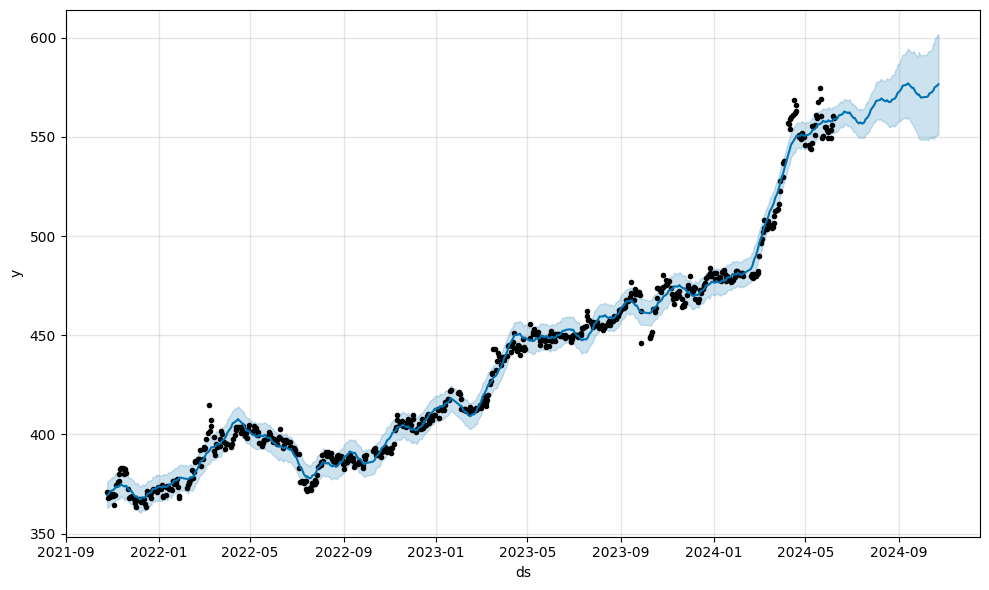

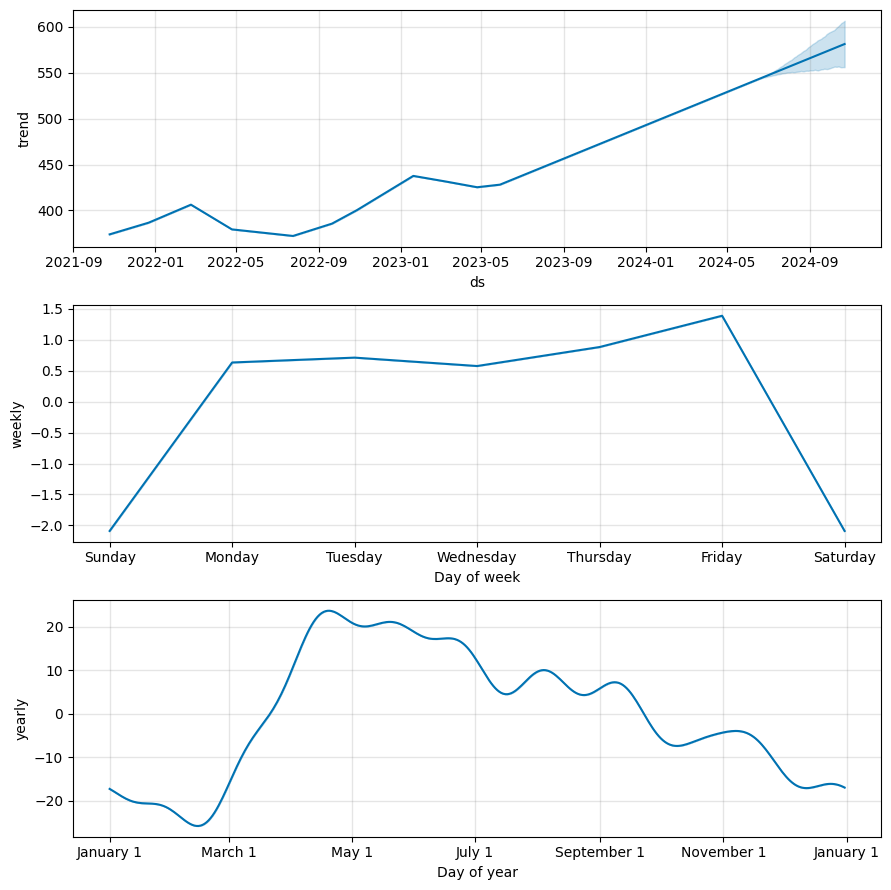

Оценки на полном датасете:
MAE: 4.79
MSE: 55.70
RMSE: 7.46
MAPE: 1.01%

Оценки только на тестовой части:
MAE: 11.97
MSE: 272.50
RMSE: 16.51
MAPE: 2.05%


In [39]:
pred = pipeline("feature_1", df_start_date="23.10.21")

05:07:24 - cmdstanpy - INFO - Chain [1] start processing
05:07:24 - cmdstanpy - INFO - Chain [1] done processing


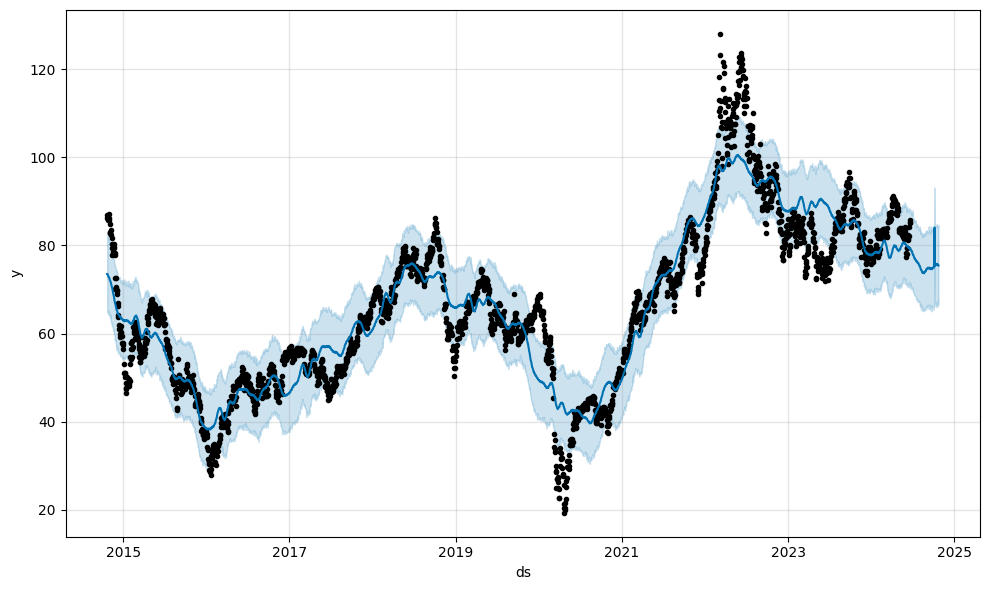

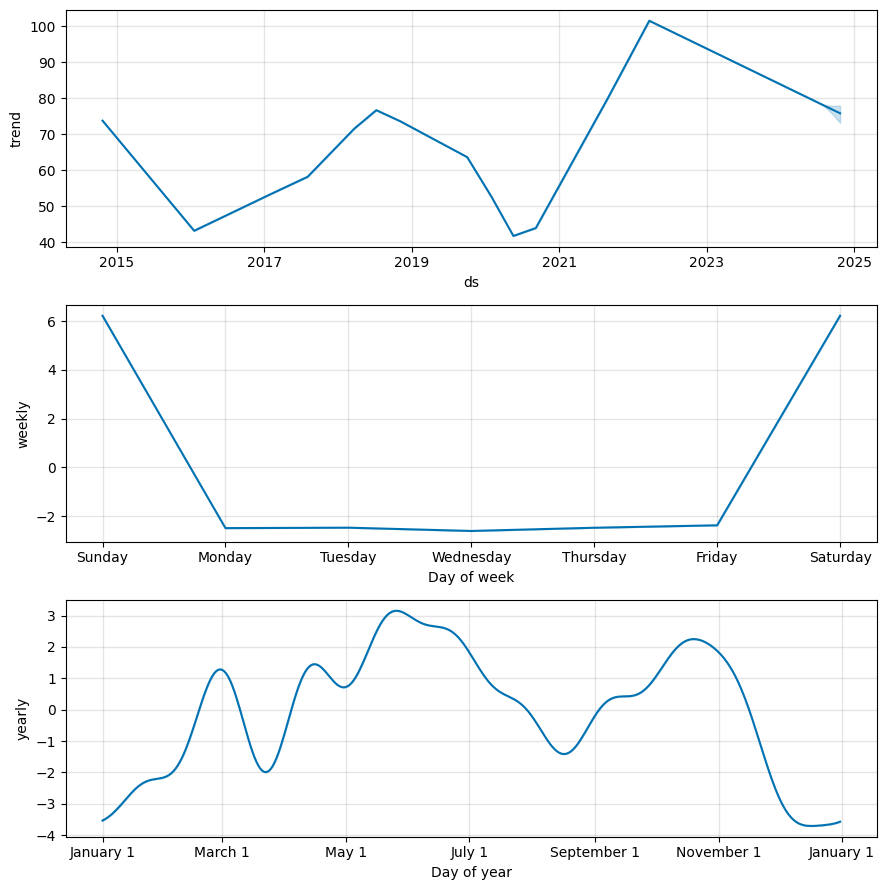

Оценки на полном датасете:
MAE: 4.95
MSE: 43.48
RMSE: 6.59
MAPE: 8.21%

Оценки только на тестовой части:
MAE: 4.39
MSE: 26.30
RMSE: 5.13
MAPE: 5.43%


In [40]:
pred = pipeline("feature_2")

05:07:26 - cmdstanpy - INFO - Chain [1] start processing
05:07:26 - cmdstanpy - INFO - Chain [1] done processing


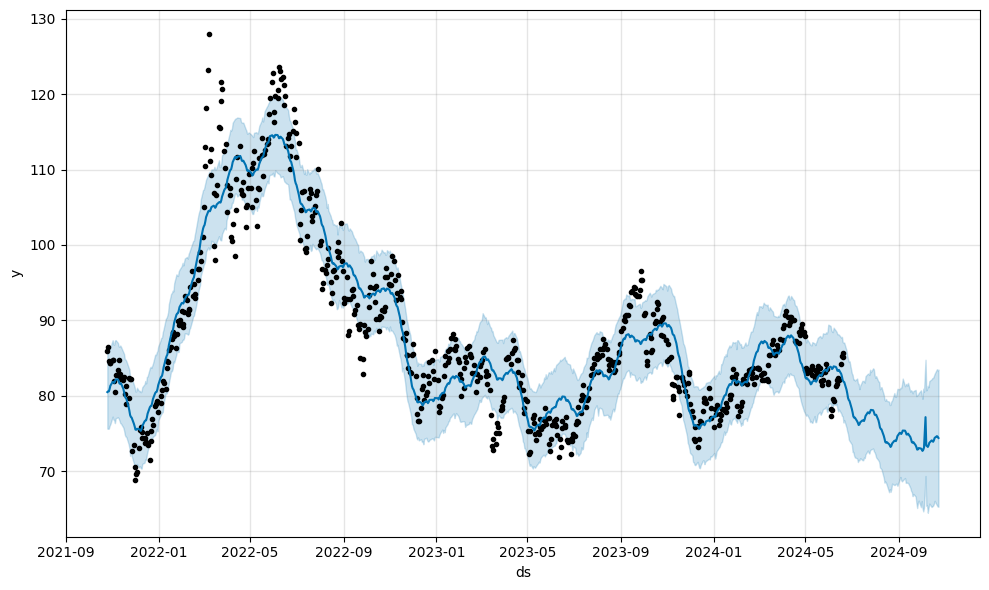

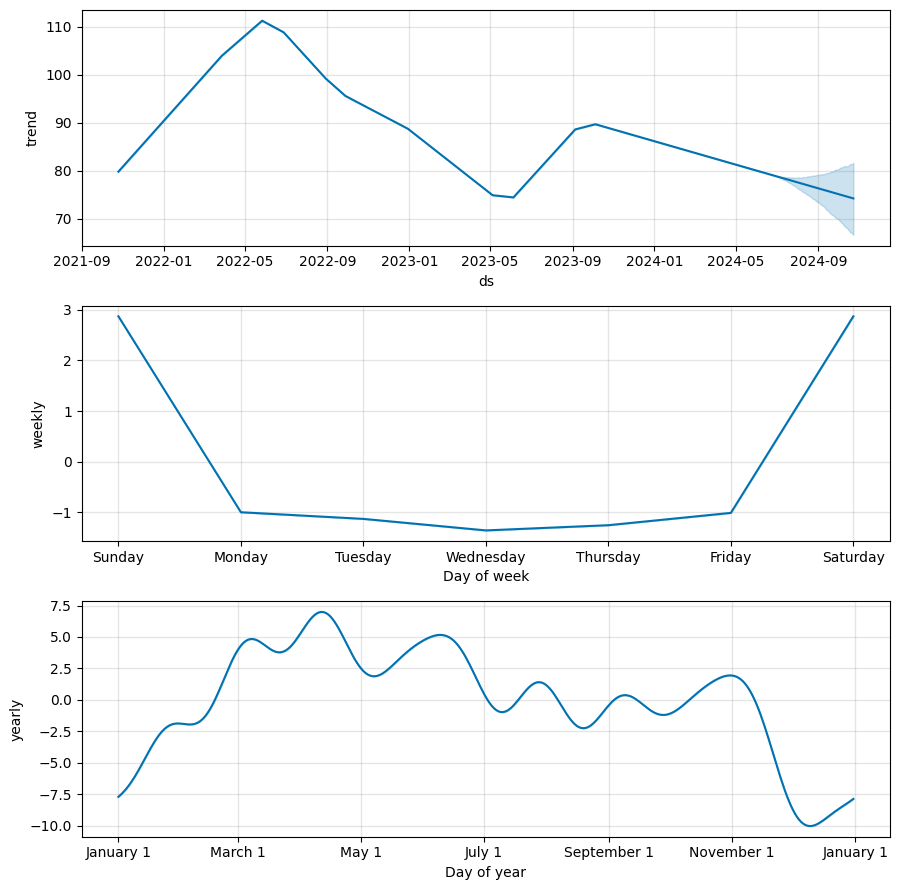

Оценки на полном датасете:
MAE: 3.11
MSE: 16.73
RMSE: 4.09
MAPE: 3.53%

Оценки только на тестовой части:
MAE: 4.13
MSE: 25.05
RMSE: 5.01
MAPE: 5.10%


In [41]:
pred = pipeline("feature_2", df_start_date="23.10.21")

05:07:27 - cmdstanpy - INFO - Chain [1] start processing
05:07:28 - cmdstanpy - INFO - Chain [1] done processing


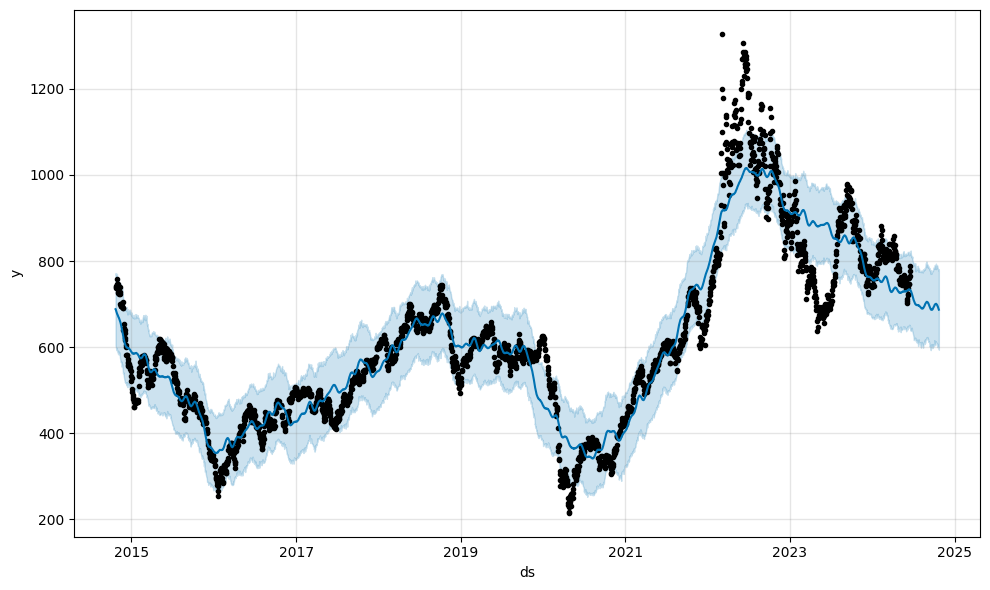

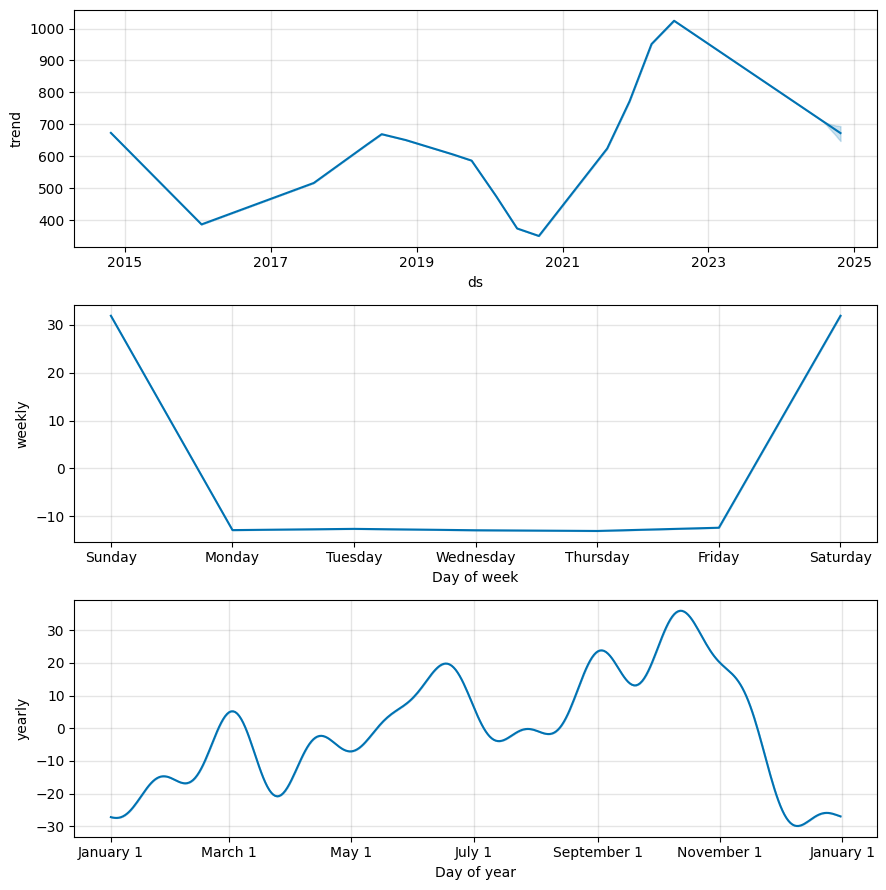

Оценки на полном датасете:
MAE: 47.88
MSE: 4416.16
RMSE: 66.45
MAPE: 8.15%

Оценки только на тестовой части:
MAE: 39.40
MSE: 2158.30
RMSE: 46.46
MAPE: 5.40%


In [42]:
preds = pipeline("feature_3")

05:07:30 - cmdstanpy - INFO - Chain [1] start processing
05:07:30 - cmdstanpy - INFO - Chain [1] done processing


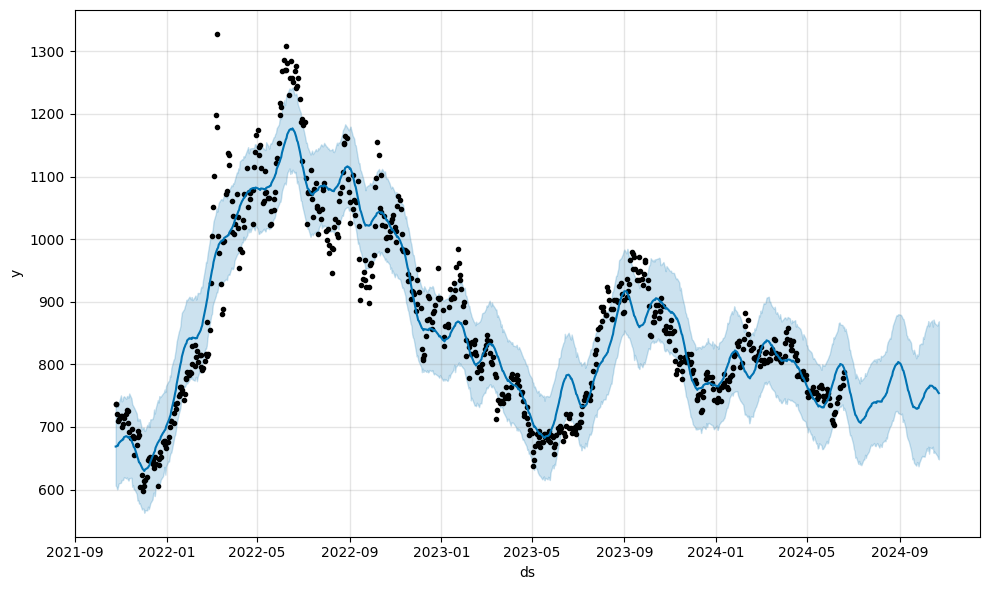

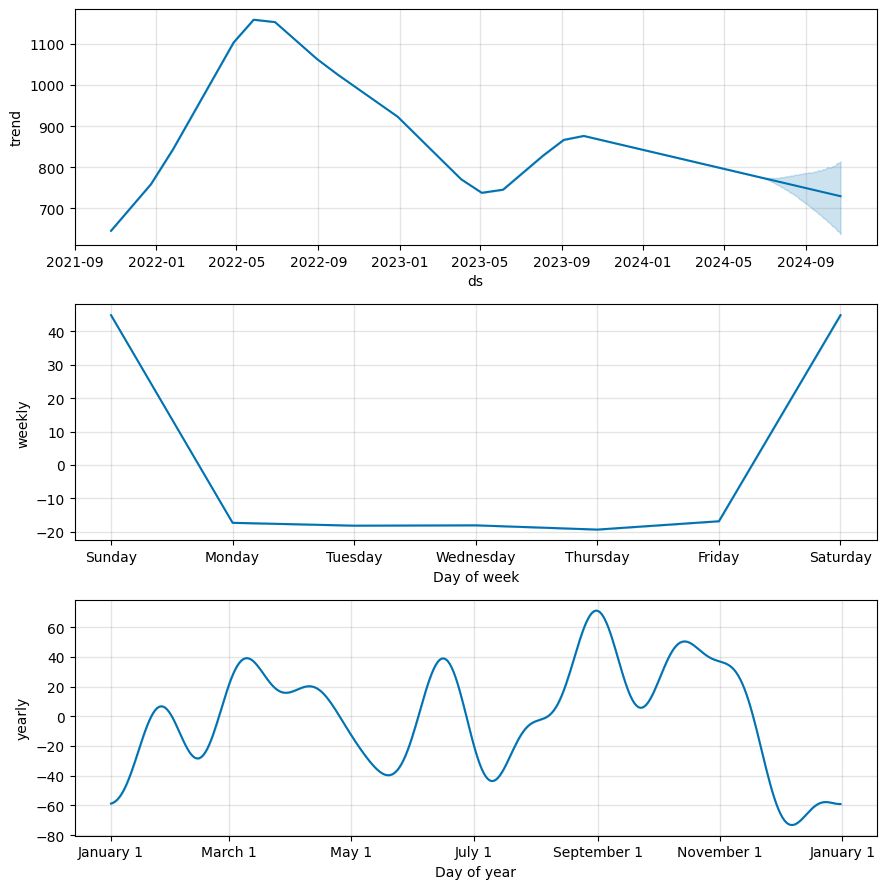

Оценки на полном датасете:
MAE: 41.10
MSE: 2913.82
RMSE: 53.98
MAPE: 4.86%

Оценки только на тестовой части:
MAE: 62.66
MSE: 5241.21
RMSE: 72.40
MAPE: 9.02%


In [43]:
preds = pipeline("feature_3", df_start_date="23.10.21")

05:07:31 - cmdstanpy - INFO - Chain [1] start processing
05:07:32 - cmdstanpy - INFO - Chain [1] done processing


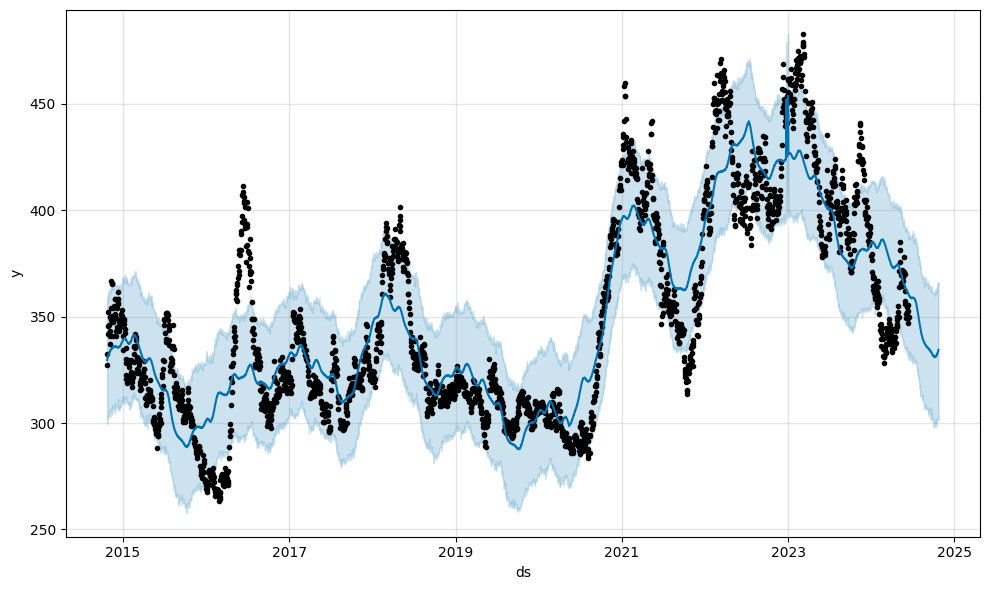

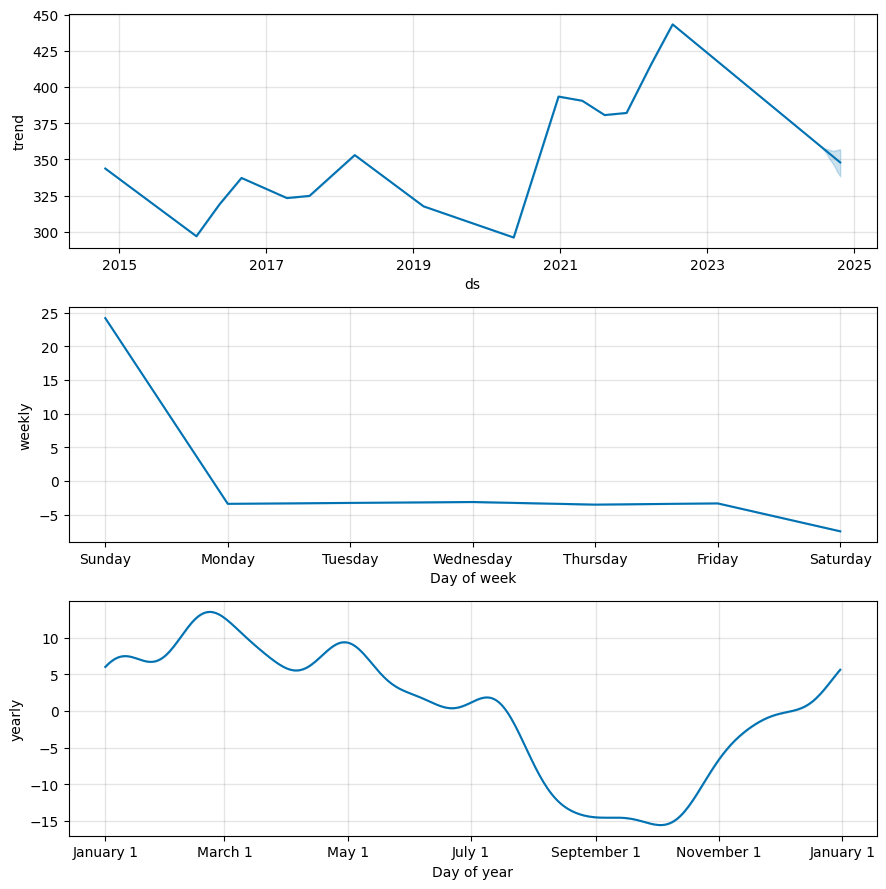

Оценки на полном датасете:
MAE: 17.78
MSE: 504.06
RMSE: 22.45
MAPE: 5.07%

Оценки только на тестовой части:
MAE: 22.35
MSE: 641.59
RMSE: 25.33
MAPE: 7.05%


In [44]:
preds = pipeline("feature_4")

05:07:34 - cmdstanpy - INFO - Chain [1] start processing
05:07:34 - cmdstanpy - INFO - Chain [1] done processing


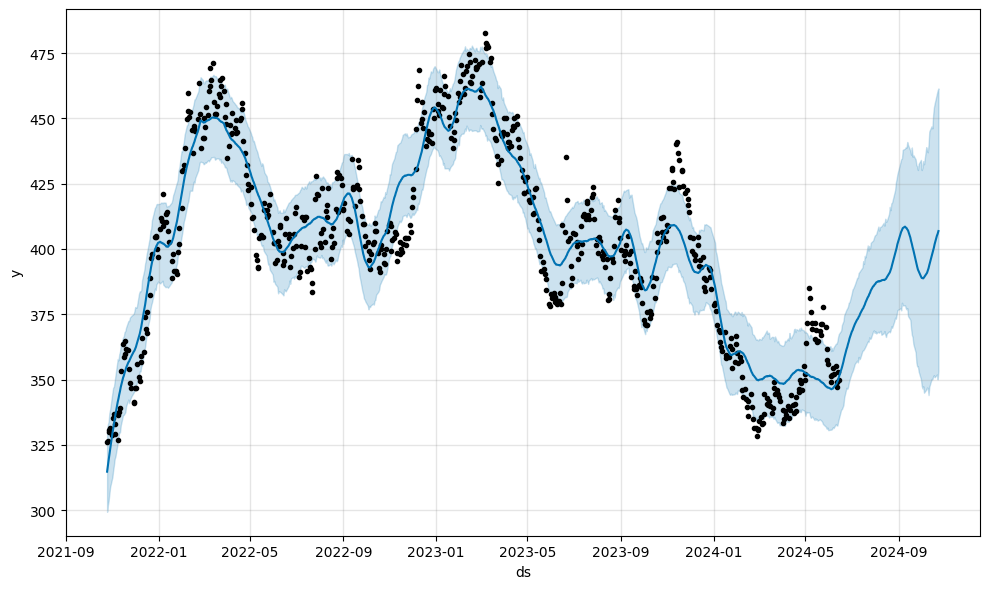

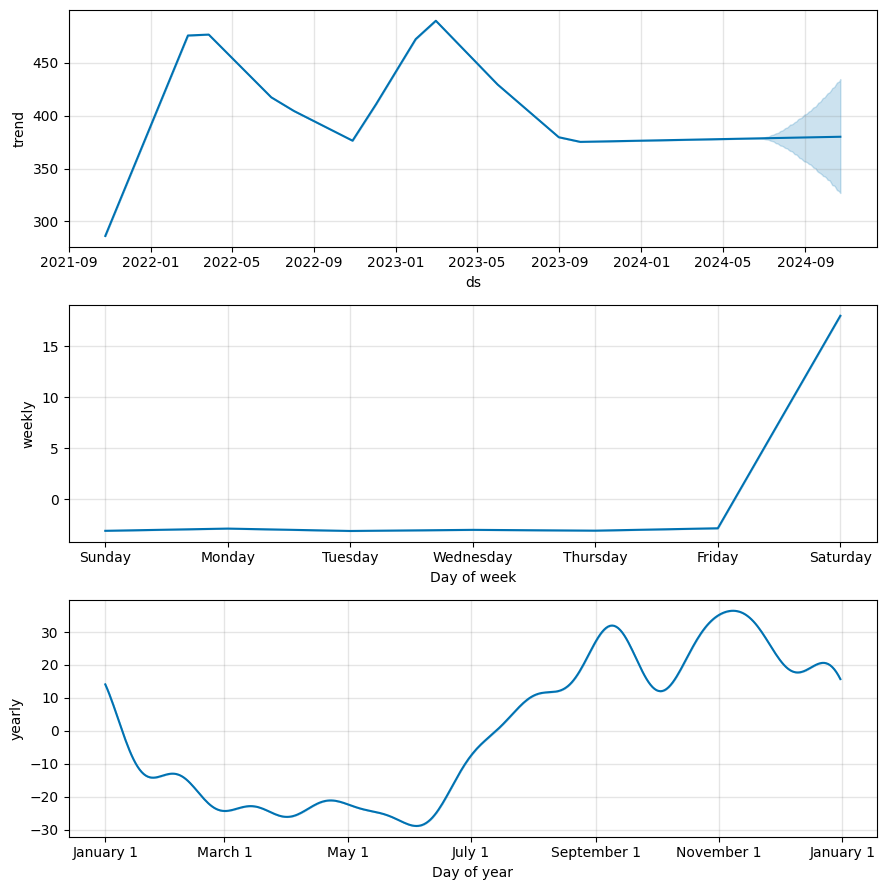

Оценки на полном датасете:
MAE: 16.58
MSE: 712.04
RMSE: 26.68
MAPE: 4.66%

Оценки только на тестовой части:
MAE: 66.65
MSE: 4913.54
RMSE: 70.10
MAPE: 20.96%


In [45]:
preds = pipeline("feature_4", df_start_date="23.10.21")

Сводка по MAPE на тесте:

feature_1 - SGE Gold T+D CNY Cash Spot - 1 (XAUTD=SGEX)
- Полные данные: 4.66%
- Три года: 2.05%

feature_2 - Фьючерс на нефть Brent - Дек. '24 (LCOZ4)
- Полные данные: 5.43%
- Три года: 5.10%

feature_3 - Фьючерс на газойль Лондон - Нояб. '24 (LGOX4)
- Полные данные: 5.10%
- Три года: 9.02%

feature_4 - US Soybean Meal Futures - Март '25 (SMc3)
- Полные данные: 7.05%
- Три года: 20.96%

Возьмем для обучения регрессоров те периоды, которые показали лучшие оценки на тесте

In [46]:
preds_feature_1 = pipeline("feature_1", df_start_date="23.10.21", plot_prophet=False, print_scores=False, future_only=True)
preds_feature_2 = pipeline("feature_2", df_start_date="23.10.21", plot_prophet=False, print_scores=False, future_only=True)
preds_feature_3 = pipeline("feature_3", plot_prophet=False, print_scores=False, future_only=True)
preds_feature_4 = pipeline("feature_4", plot_prophet=False, print_scores=False, future_only=True)

05:07:35 - cmdstanpy - INFO - Chain [1] start processing
05:07:35 - cmdstanpy - INFO - Chain [1] done processing
05:07:36 - cmdstanpy - INFO - Chain [1] start processing
05:07:36 - cmdstanpy - INFO - Chain [1] done processing
05:07:36 - cmdstanpy - INFO - Chain [1] start processing
05:07:37 - cmdstanpy - INFO - Chain [1] done processing
05:07:37 - cmdstanpy - INFO - Chain [1] start processing
05:07:38 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
def create_regressor(table_name, predictions, datecol_name="Дата", target_name="Цена"):
    df = pd.read_csv(f"{table_name}.csv")
    df = df_transform(df, fill_date_gaps=False)

    horizon = len(predictions)
    df_past = df.iloc[:-horizon].rename(columns={datecol_name: "ds", target_name: table_name})[["ds", table_name]].copy()
    regressor = pd.concat([df_past, predictions[["ds", "yhat"]].rename(columns={"yhat": table_name})], ignore_index=True)
    return regressor

In [48]:
regressor_feature_1 = create_regressor("feature_1", preds_feature_1)
regressor_feature_2 = create_regressor("feature_2", preds_feature_2)
regressor_feature_3 = create_regressor("feature_3", preds_feature_3)
regressor_feature_4 = create_regressor("feature_4", preds_feature_4)

In [49]:
df_target = pd.read_csv("target.csv")
df_target = df_transform(df_target, fill_date_gaps=False, df_start_date="23.10.21")

df_target_full = df_target.rename(columns={"Дата": "ds", "Цена": "y"})[["ds", "y"]].copy()
df_target_full = df_target_full.merge(regressor_feature_1, on="ds", how="left")
df_target_full = df_target_full.merge(regressor_feature_2, on="ds", how="left")
df_target_full = df_target_full.merge(regressor_feature_3, on="ds", how="left")
df_target_full = df_target_full.merge(regressor_feature_4, on="ds", how="left")
df_target_full = df_target_full.ffill()
df_target_full.head()

ds       y  feature_1  feature_2  feature_3  feature_4
0 2021-10-25  282.00     371.20      85.99     737.00      326.2
1 2021-10-26  284.75     367.87      86.40     736.00      326.5
2 2021-10-27  284.75     369.44      84.58     721.25      329.9
3 2021-10-28  283.00     370.67      84.32     708.75      330.6
4 2021-10-29  283.25     368.45      84.38     712.25      331.4

In [50]:
def test_regressors(regressors, df_full, train_test_split_days=90):
    df_train = df_target_full.iloc[:-train_test_split_days]
    df_test = df_target_full.iloc[-train_test_split_days:]
    regressors = list(regressors)
    
    model = Prophet()
    for r in regressors:
        model.add_regressor(r)
    model.fit(df_train)

    future = pd.concat([df_train[["ds"] + regressors], df_test[["ds"] + regressors]], ignore_index=True)
    forecast = model.predict(future)  

    
    predictions = forecast[["ds", "yhat"]]
    predictions_test = forecast[["ds", "yhat"]].iloc[-train_test_split_days:]

    print("Использованные регрессоры:", regressors)
    print(" Оценки на полном датасете:")
    score_model(df_full["y"].values, predictions["yhat"].values)
    print()
    
    print(" Оценки только на тестовой части:")
    score_model(df_test["y"].values, predictions_test["yhat"].values)

Будут тестироваться все возможные комбинации регрессоров в обучении модели

In [51]:
import itertools

regressors = [
    "feature_1", 
    "feature_2", 
    "feature_3", 
    "feature_4"
]

for combination_len in range(len(regressors)):
    for reg_combination in itertools.combinations(regressors, combination_len + 1):
         test_regressors(reg_combination, df_target_full, train_test_split_days=90)

05:07:39 - cmdstanpy - INFO - Chain [1] start processing
05:07:39 - cmdstanpy - INFO - Chain [1] done processing
05:07:39 - cmdstanpy - INFO - Chain [1] start processing


Использованные регрессоры: ['feature_1']
 Оценки на полном датасете:
MAE: 10.49
MSE: 190.22
RMSE: 13.79
MAPE: 4.00%

 Оценки только на тестовой части:
MAE: 8.62
MSE: 99.02
RMSE: 9.95
MAPE: 4.04%


05:07:40 - cmdstanpy - INFO - Chain [1] done processing
05:07:40 - cmdstanpy - INFO - Chain [1] start processing


Использованные регрессоры: ['feature_2']
 Оценки на полном датасете:
MAE: 11.52
MSE: 219.79
RMSE: 14.83
MAPE: 4.35%

 Оценки только на тестовой части:
MAE: 7.05
MSE: 91.46
RMSE: 9.56
MAPE: 3.22%


05:07:40 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_3']
 Оценки на полном датасете:
MAE: 12.68
MSE: 254.44
RMSE: 15.95
MAPE: 4.85%

 Оценки только на тестовой части:
MAE: 15.13
MSE: 262.43
RMSE: 16.20
MAPE: 6.93%


05:07:41 - cmdstanpy - INFO - Chain [1] start processing
05:07:41 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_4']
 Оценки на полном датасете:
MAE: 11.10
MSE: 209.28
RMSE: 14.47
MAPE: 4.31%

 Оценки только на тестовой части:
MAE: 18.14
MSE: 427.55
RMSE: 20.68
MAPE: 8.44%


05:07:41 - cmdstanpy - INFO - Chain [1] start processing
05:07:42 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_1', 'feature_2']
 Оценки на полном датасете:
MAE: 10.79
MSE: 197.25
RMSE: 14.04
MAPE: 4.08%

 Оценки только на тестовой части:
MAE: 6.08
MSE: 62.23
RMSE: 7.89
MAPE: 2.82%


05:07:42 - cmdstanpy - INFO - Chain [1] start processing
05:07:42 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_1', 'feature_3']
 Оценки на полном датасете:
MAE: 11.72
MSE: 224.26
RMSE: 14.98
MAPE: 4.45%

 Оценки только на тестовой части:
MAE: 10.48
MSE: 138.36
RMSE: 11.76
MAPE: 4.79%


05:07:43 - cmdstanpy - INFO - Chain [1] start processing
05:07:43 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_1', 'feature_4']
 Оценки на полном датасете:
MAE: 10.83
MSE: 194.35
RMSE: 13.94
MAPE: 4.17%

 Оценки только на тестовой части:
MAE: 13.36
MSE: 235.67
RMSE: 15.35
MAPE: 6.22%


05:07:43 - cmdstanpy - INFO - Chain [1] start processing
05:07:43 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_2', 'feature_3']
 Оценки на полном датасете:
MAE: 12.60
MSE: 251.71
RMSE: 15.87
MAPE: 4.82%

 Оценки только на тестовой части:
MAE: 14.84
MSE: 253.79
RMSE: 15.93
MAPE: 6.80%


05:07:44 - cmdstanpy - INFO - Chain [1] start processing
05:07:44 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_2', 'feature_4']
 Оценки на полном датасете:
MAE: 11.53
MSE: 216.53
RMSE: 14.72
MAPE: 4.48%

 Оценки только на тестовой части:
MAE: 19.08
MSE: 489.89
RMSE: 22.13
MAPE: 8.85%


05:07:45 - cmdstanpy - INFO - Chain [1] start processing
05:07:45 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_3', 'feature_4']
 Оценки на полном датасете:
MAE: 10.49
MSE: 180.61
RMSE: 13.44
MAPE: 3.95%

 Оценки только на тестовой части:
MAE: 7.72
MSE: 91.62
RMSE: 9.57
MAPE: 3.52%


05:07:45 - cmdstanpy - INFO - Chain [1] start processing
05:07:45 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_1', 'feature_2', 'feature_3']
 Оценки на полном датасете:
MAE: 11.69
MSE: 223.31
RMSE: 14.94
MAPE: 4.44%

 Оценки только на тестовой части:
MAE: 10.75
MSE: 142.72
RMSE: 11.95
MAPE: 4.91%


05:07:46 - cmdstanpy - INFO - Chain [1] start processing
05:07:46 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_1', 'feature_2', 'feature_4']
 Оценки на полном датасете:
MAE: 11.20
MSE: 200.33
RMSE: 14.15
MAPE: 4.32%

 Оценки только на тестовой части:
MAE: 15.21
MSE: 311.15
RMSE: 17.64
MAPE: 7.06%


05:07:46 - cmdstanpy - INFO - Chain [1] start processing
05:07:47 - cmdstanpy - INFO - Chain [1] done processing
05:07:47 - cmdstanpy - INFO - Chain [1] start processing


Использованные регрессоры: ['feature_1', 'feature_3', 'feature_4']
 Оценки на полном датасете:
MAE: 10.36
MSE: 176.48
RMSE: 13.28
MAPE: 3.91%

 Оценки только на тестовой части:
MAE: 7.56
MSE: 83.47
RMSE: 9.14
MAPE: 3.47%


05:07:47 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_2', 'feature_3', 'feature_4']
 Оценки на полном датасете:
MAE: 10.57
MSE: 185.05
RMSE: 13.60
MAPE: 3.98%

 Оценки только на тестовой части:
MAE: 7.12
MSE: 76.13
RMSE: 8.73
MAPE: 3.24%


05:07:48 - cmdstanpy - INFO - Chain [1] start processing
05:07:48 - cmdstanpy - INFO - Chain [1] done processing


Использованные регрессоры: ['feature_1', 'feature_2', 'feature_3', 'feature_4']
 Оценки на полном датасете:
MAE: 10.60
MSE: 187.55
RMSE: 13.69
MAPE: 3.98%

 Оценки только на тестовой части:
MAE: 6.63
MSE: 64.99
RMSE: 8.06
MAPE: 3.03%


**target** - Фьючерс на мукомольную пшеницу №2 - (BL2c1)

**feature_1** - SGE Gold T+D CNY Cash Spot - 1 (XAUTD=SGEX)

**feature_2** - Фьючерс на нефть Brent - Дек. '24 (LCOZ4)

**feature_3** - Фьючерс на газойль Лондон - Нояб. '24 (LGOX4)

**feature_4** - US Soybean Meal Futures - Март '25 (SMc3)

Оценки модели без регрессоров:

Оценки только на тестовой части:
- MAE: 7.86
- MSE: 85.13
- RMSE: 9.23
- MAPE: 3.70%

Оценка улучшилась при использовании следующих комбинаций регрессоров:

['feature_2'] - 3.22%

['feature_1', 'feature_2'] - **2.82%**

['feature_3', 'feature_4'] - 3.52%

['feature_1', 'feature_3', 'feature_4'] - 3.47%

['feature_2', 'feature_3', 'feature_4'] -  3.24%

['feature_1', 'feature_2', 'feature_3', 'feature_4'] - 3.03%

#### Попробуем использовать тьюнинг гиперпараметров модели для улучшения результата

In [52]:
# Дополнительно разделим данные на валидационный сет, чтобы не показывать модели тестовый набор при оптимизации
df_target = pd.read_csv("target.csv")
df_target = df_transform(df_target, fill_date_gaps=False)

# Возьмем по 90 дней на валидацию при оптимизации и на тест
val_split_days = 90 
test_split_days = 90  

df = df_target.rename(columns={"Дата": "ds", "Цена": "y"})[["ds", "y"]].copy()
df_train = df.iloc[:-(val_split_days + test_split_days)].copy()
df_val = df.iloc[-(val_split_days + test_split_days):-test_split_days].copy()
df_tеst = df.iloc[-test_split_days:].copy()

display(df_train)
display(df_val)
display(df_tеst)

ds       y
0    2014-10-23  170.25
1    2014-10-24  165.75
2    2014-10-27  165.00
3    2014-10-28  169.50
4    2014-10-29  173.50
...         ...     ...
2377 2024-02-05  210.00
2378 2024-02-06  211.00
2379 2024-02-07  209.00
2380 2024-02-08  205.25
2381 2024-02-09  209.50

[2382 rows x 2 columns]

ds       y
2382 2024-02-12  208.50
2383 2024-02-13  209.00
2384 2024-02-14  207.50
2385 2024-02-15  206.00
2386 2024-02-16  203.25
...         ...     ...
2467 2024-06-13  238.50
2468 2024-06-14  236.75
2469 2024-06-17  230.25
2470 2024-06-18  229.00
2471 2024-06-19  230.50

[90 rows x 2 columns]

ds       y
2472 2024-06-20  226.75
2473 2024-06-21  224.50
2474 2024-06-24  222.25
2475 2024-06-25  221.00
2476 2024-06-26  223.50
...         ...     ...
2557 2024-10-17  230.25
2558 2024-10-18  226.50
2559 2024-10-21  224.25
2560 2024-10-22  223.50
2561 2024-10-23  223.75

[90 rows x 2 columns]

In [53]:
# Заглушивает уведомления от Prophet, чтобы не захламляли вывод ячейки
import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

In [54]:
from hyperopt import fmin, tpe, hp, Trials
from sklearn.metrics import mean_absolute_error
import numpy as np

def objective(params):
    model = Prophet(
        changepoint_prior_scale=params["changepoint_prior_scale"],
        seasonality_prior_scale=params["seasonality_prior_scale"],
        seasonality_mode=params["seasonality_mode"],
    )

    model.fit(df_train)
    forecast = model.predict(df_val)
    mae = mean_absolute_error(df_val["y"], forecast["yhat"])
    return mae

# Сетка поиска подобрана в соответствии с рекомендациями из официальной документации Prophet
param_space = {
    "changepoint_prior_scale": hp.loguniform("changepoint_prior_scale", np.log(0.001), np.log(0.5)),
    "seasonality_prior_scale": hp.loguniform("seasonality_prior_scale", np.log(0.01), np.log(10)),
    "seasonality_mode": hp.choice("seasonality_mode", ["additive", "multiplicative"])
}

In [55]:
trials = Trials()
best = fmin(objective, param_space, algo=tpe.suggest, max_evals=500, trials=trials)
print("Лучшие параметры:\n", best)

100%|██████████████████████████████████████████████| 500/500 [08:06<00:00,  1.03trial/s, best loss: 22.666592834387416]
Лучшие параметры:
 {'changepoint_prior_scale': np.float64(0.007189133631497106), 'seasonality_mode': np.int64(1), 'seasonality_prior_scale': np.float64(0.03266467946876652)}


In [56]:
from hyperopt import space_eval

best_params = space_eval(param_space, best)
best_params

{'changepoint_prior_scale': 0.007189133631497106,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 0.03266467946876652}

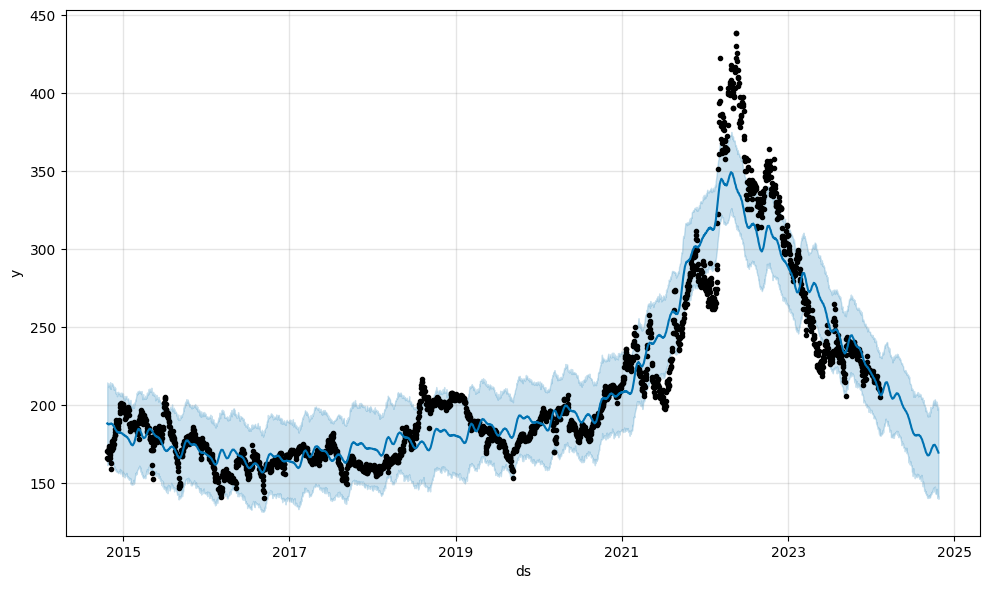

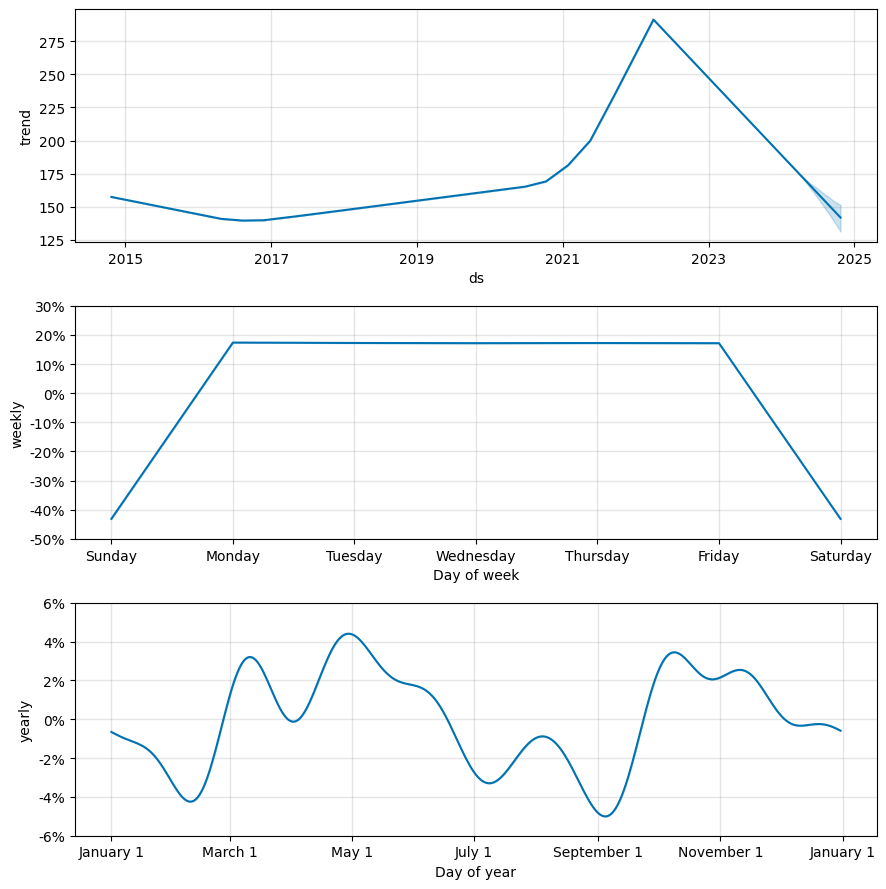

In [57]:
model = Prophet(**best_params)
model.fit(df_train)

future = pd.concat([df_train[["ds"]], df_val[["ds"]], df_tеst[["ds"]]], ignore_index=True)
forecast = model.predict(future)  

plot(model, forecast)
plot_components(model, forecast)
plt.show()

In [58]:
# Оценки модели без оптимизации:

# Оценки только на тестовой части:
# MAE: 53.26
# MSE: 2958.16
# RMSE: 54.39
# MAPE: 24.35%

In [59]:
predictions = forecast[["ds", "yhat"]]
predictions_test = forecast[["ds", "yhat"]].iloc[-test_split_days:]

print("Оценки на полном датасете:")
score_model(df["y"].values, predictions["yhat"].values)
print()

print("Оценки только на тестовой части:")
score_model(df_tеst["y"].values, predictions_test["yhat"].values)

Оценки на полном датасете:
MAE: 15.33
MSE: 449.04
RMSE: 21.19
MAPE: 6.86%

Оценки только на тестовой части:
MAE: 41.70
MSE: 1841.13
RMSE: 42.91
MAPE: 19.02%


Оптимизация гиперпараметров помогла улучшить результат при использовании полного набора данных

Повторим эксперимент для более короткого окна данных

In [60]:
df_target = pd.read_csv("target.csv")
df_target = df_transform(df_target, fill_date_gaps=False, df_start_date="23.10.21")

# Возьмем 45 дней на валидацию при оптимизации и 90 на тест
val_split_days = 45
test_split_days = 90  

df = df_target.rename(columns={"Дата": "ds", "Цена": "y"})[["ds", "y"]].copy()
df_train = df.iloc[:-(val_split_days + test_split_days)].copy()
df_val = df.iloc[-(val_split_days + test_split_days):-test_split_days].copy()
df_tеst = df.iloc[-test_split_days:].copy()

display(df_train)
display(df_val)
display(df_tеst)

ds       y
0   2021-10-25  282.00
1   2021-10-26  284.75
2   2021-10-27  284.75
3   2021-10-28  283.00
4   2021-10-29  283.25
..         ...     ...
631 2024-04-10  204.50
632 2024-04-11  201.00
633 2024-04-12  203.50
634 2024-04-15  203.75
635 2024-04-16  203.75

[636 rows x 2 columns]

ds       y
636 2024-04-17  203.25
637 2024-04-18  205.75
638 2024-04-19  206.50
639 2024-04-22  215.50
640 2024-04-23  209.50
641 2024-04-24  208.50
642 2024-04-25  208.75
643 2024-04-26  211.75
644 2024-04-29  208.25
645 2024-04-30  205.00
646 2024-05-02  204.75
647 2024-05-03  209.75
648 2024-05-06  215.25
649 2024-05-07  209.75
650 2024-05-08  208.75
651 2024-05-09  215.25
652 2024-05-10  211.75
653 2024-05-13  258.75
654 2024-05-14  249.75
655 2024-05-15  250.75
656 2024-05-16  248.50
657 2024-05-17  246.75
658 2024-05-20  256.50
659 2024-05-21  257.00
660 2024-05-22  259.25
661 2024-05-23  258.25
662 2024-05-24  261.25
663 2024-05-27  269.00
664 2024-05-28  264.75
665 2024-05-29  263.25
666 2024-05-30  258.50
667 2024-05-31  259.25
668 2024-06-03  258.75
669 2024-06-04  258.50
670 2024-06-05  254.25
671 2024-06-06  251.25
672 2024-06-07  243.75
673 2024-06-10  239.00
674 2024-06-11  246.50
675 2024-06-12  240.00
676 2024-06-13  238.50
677 2024-06-14  236.75
678 2024-06-17  230.25
679 2024-06-18  229.00
680 2024-06-19  230.50

ds       y
681 2024-06-20  226.75
682 2024-06-21  224.50
683 2024-06-24  222.25
684 2024-06-25  221.00
685 2024-06-26  223.50
..         ...     ...
766 2024-10-17  230.25
767 2024-10-18  226.50
768 2024-10-21  224.25
769 2024-10-22  223.50
770 2024-10-23  223.75

[90 rows x 2 columns]

In [61]:
trials = Trials()
best = fmin(objective, param_space, algo=tpe.suggest, max_evals=500, trials=trials)
print("Лучшие параметры:\n", best)

100%|███████████████████████████████████████████████| 500/500 [07:11<00:00,  1.16trial/s, best loss: 13.83907811236487]
Лучшие параметры:
 {'changepoint_prior_scale': np.float64(0.38584850491707706), 'seasonality_mode': np.int64(1), 'seasonality_prior_scale': np.float64(8.399719544627981)}


In [62]:
best_params = space_eval(param_space, best)
best_params

{'changepoint_prior_scale': 0.38584850491707706,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 8.399719544627981}

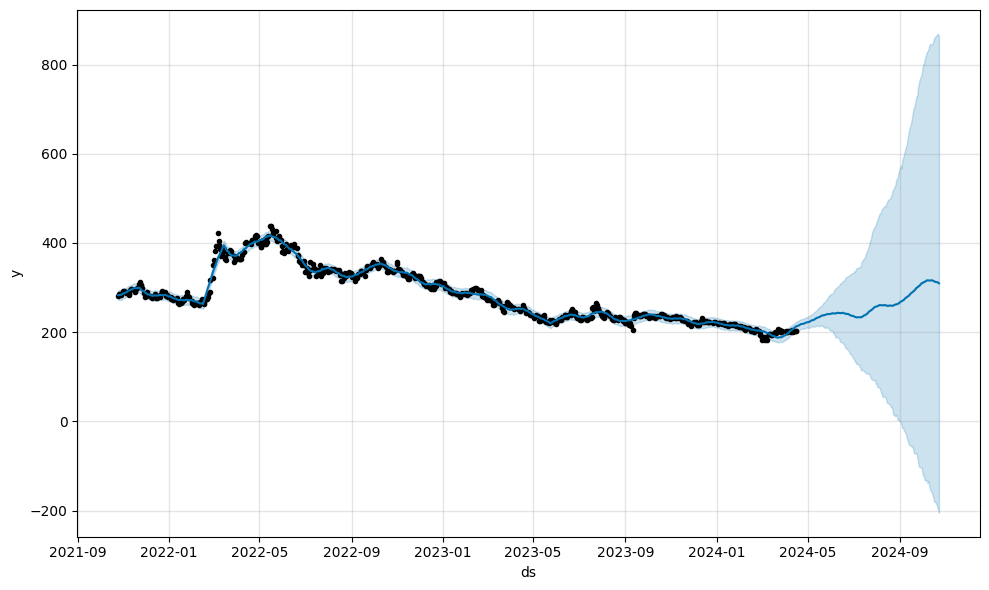

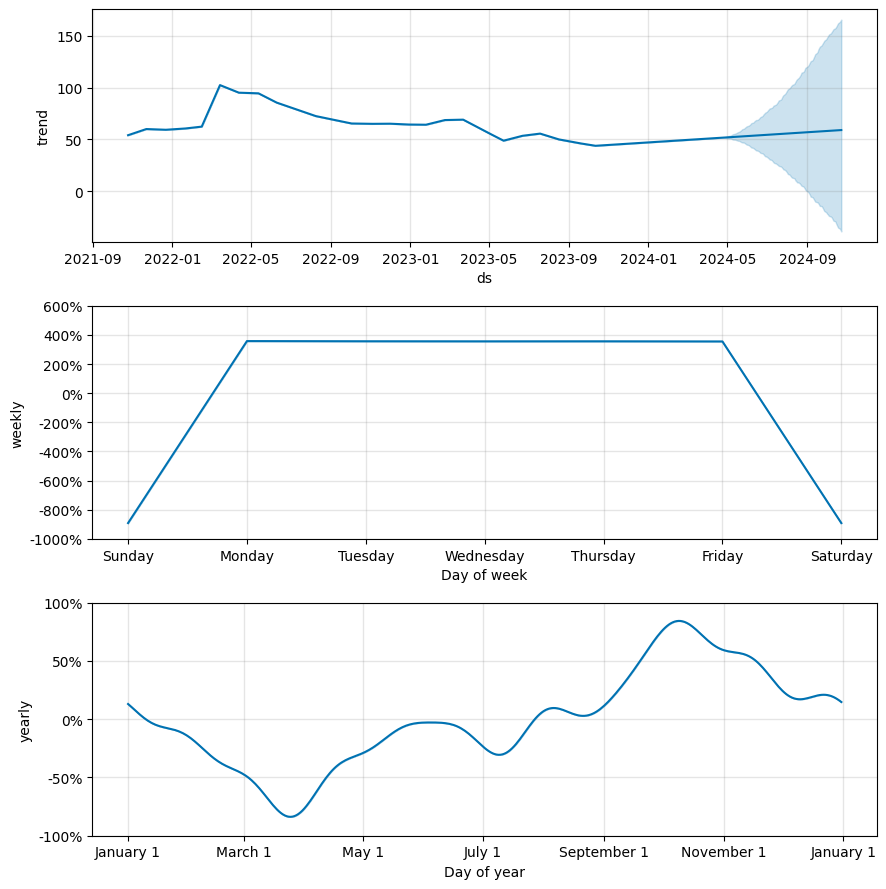

In [63]:
model = Prophet(**best_params)
model.fit(df_train)

future = pd.concat([df_train[["ds"]], df_val[["ds"]], df_tеst[["ds"]]], ignore_index=True)
forecast = model.predict(future)  

plot(model, forecast)
plot_components(model, forecast)
plt.show()

In [64]:
# Оценки только на тестовой части:
# MAE: 7.86
# MSE: 85.13
# RMSE: 9.23
# MAPE: 3.70%

In [65]:
predictions = forecast[["ds", "yhat"]]
predictions_test = forecast[["ds", "yhat"]].iloc[-test_split_days:]

print("Оценки на полном датасете:")
score_model(df["y"].values, predictions["yhat"].values)
print()

print("Оценки только на тестовой части:")
score_model(df_tеst["y"].values, predictions_test["yhat"].values)

Оценки на полном датасете:
MAE: 11.85
MSE: 481.28
RMSE: 21.94
MAPE: 4.90%

Оценки только на тестовой части:
MAE: 52.55
MSE: 3520.76
RMSE: 59.34
MAPE: 24.33%


Подбор гиперпараметров для модели, обученной на 3 годах, сильно ухудшил оценку на тестовом сете при использовании 45 дней для валидации и 90 дней для теста

Я пробовал использовать разные размеры валидационного набора (90, 60, 45, 30), но результат не улучшился ни в одном из них. Возможно это связано с тем, что валидационный набор попадает на окно данных, которое плохо описывает общие закономерности во временном ряде, и оптимизация на нем не помогает улучшить поведение модели

## XGBoost

Обучим XGBoost Regressor для предсказания целевой переменной

In [67]:
def calculate_lags(dataframe, lag_windows, mean_windows, std_windows, columns=["target"]):
    df = dataframe.copy()
    for col in columns:
        for lag_window in lag_windows:
            col_name = f"{col}_lag_{lag_window}"
            df[col_name] = df[col].shift(lag_window)
        for mean_window in mean_windows:
            col_name = f"{col}_rolling_mean_{mean_window}"
            df[col_name] = df[col].shift(1).rolling(window=mean_window).mean()
        for std_window in std_windows:
            col_name = f"{col}_rolling_std_{std_window}"
            df[col_name] = df[col].shift(1).rolling(window=mean_window).std()
        df[f"{col}_pct_change"] = df[col].shift(1).pct_change()
        df[f"{col}_diff"] = df[col].shift(1).diff()
    return df

In [68]:
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

df_target = pd.read_csv("target.csv")
df_target = df_transform(df_target, fill_date_gaps=False)

df = df_target.rename(columns={"Дата": "date", "Цена": "target"}).copy()
df["day_of_year"] = df["date"].apply(lambda x: x.day_of_year)
df["day_of_week"] = df["date"].apply(lambda x: x.day_of_week)
df["day_sin"] = np.sin(0.2 * df["day_of_year"])
df["day_cos"] = np.cos(0.2 * df["day_of_year"])

cols_to_drop = ["date", "Откр.", "Макс.", "Мин.", "Объём", "Изм. %", "День недели", "Выходной"]
X = df.drop(columns=cols_to_drop)  
y = df["target"]  

lag_windows = [1, 3, 5, 7, 14, 30]
rolling_mean_windows = [7, 14, 30]
rolling_std_windows = [7, 14, 30]

train_test_split_days = 90
X_train = calculate_lags(X.iloc[:-train_test_split_days], lag_windows, rolling_mean_windows, rolling_std_windows).drop(columns=["target"])
y_train = y.iloc[:-train_test_split_days].copy()

X_test = X.iloc[-train_test_split_days:].copy().drop(columns=["target"])
y_test = y.iloc[-train_test_split_days:].copy()

X_train

Месяц  День  day_of_year  day_of_week   day_sin   day_cos  target_lag_1  \
0        10    23          296            3  0.470856 -0.882210           NaN   
1        10    24          297            4  0.286202 -0.958169        170.25   
2        10    27          300            0 -0.304811 -0.952413        165.75   
3        10    28          301            1 -0.487950 -0.872872        165.00   
4        10    29          302            2 -0.651636 -0.758532        169.50   
...     ...   ...          ...          ...       ...       ...           ...   
2467      6    13          165            3  0.999912 -0.013277        240.00   
2468      6    14          166            4  0.977343 -0.211664        238.50   
2469      6    17          169            0  0.687121 -0.726543        236.75   
2470      6    18          170            1  0.529083 -0.848570        230.25   
2471      6    19          171            2  0.349951 -0.936768        229.00   

      target_lag_3  target_lag_5  target_lag_7  target_lag_14  target_lag_30  \
0              NaN           NaN           NaN            NaN            NaN   
1              NaN           NaN           NaN            NaN            NaN   
2              NaN           NaN           NaN            NaN            NaN   
3           170.25           NaN           NaN            NaN            NaN   
4           165.75           NaN           NaN            NaN            NaN   
...            ...           ...           ...            ...            ...   
2467        239.00        251.25        258.50         261.25         204.75   
2468        246.50        243.75        254.25         269.00         209.75   
2469        240.00        239.00        251.25         264.75         215.25   
2470        238.50        246.50        243.75         263.25         209.75   
2471        236.75        240.00        239.00         258.50         208.75   

      target_rolling_mean_7  target_rolling_mean_14  target_rolling_mean_30  \
0                       NaN                     NaN                     NaN   
1                       NaN                     NaN                     NaN   
2                       NaN                     NaN                     NaN   
3                       NaN                     NaN                     NaN   
4                       NaN                     NaN                     NaN   
...                     ...                     ...                     ...   
2467             247.607143              254.857143              244.291667   
2468             244.750000              253.232143              245.416667   
2469             242.250000              250.928571              246.316667   
2470             239.250000              248.464286              246.816667   
2471             237.142857              246.017857              247.458333   

      target_rolling_std_7  target_rolling_std_14  target_rolling_std_30  \
0                      NaN                    NaN                    NaN   
1                      NaN                    NaN                    NaN   
2                      NaN                    NaN                    NaN   
3                      NaN                    NaN                    NaN   
4                      NaN                    NaN                    NaN   
...                    ...                    ...                    ...   
2467             20.089464              20.089464              20.089464   
2468             18.695419              18.695419              18.695419   
2469             17.532966              17.532966              17.532966   
2470             16.815676              16.815676              16.815676   
2471             15.681513              15.681513              15.681513   

      target_pct_change  target_diff  
0                   NaN          NaN  
1                   NaN          NaN  
2             -0.026432        -4.50  
3             -0.004525        -0.75  
4              

In [69]:
def add_lags_chain_predict(df, target, i, lag_windows, mean_windows, std_windows):
    dataframe = df.copy()

    for lag_window in lag_windows:
        lag_col_name = f"{target}_lag_{lag_window}"
        dataframe.loc[i, lag_col_name] = dataframe[target].iloc[i - lag_window]

    for mean_window in mean_windows:
        mean_col_name = f"{target}_rolling_mean_{mean_window}"
        lag_df_window = dataframe[target].iloc[i - mean_window:i]
        dataframe.loc[i, mean_col_name] = lag_df_window.mean()

    for std_window in std_windows:
        std_col_name = f"{target}_rolling_std_{std_window}"
        std_df_window = dataframe[target].iloc[i - std_window:i]
        dataframe.loc[i, std_col_name] = std_df_window.std()

    dataframe.loc[i, f"{target}_pct_change"] = (dataframe[target].iloc[i - 1] - dataframe[target].iloc[i - 2]) / dataframe[target].iloc[i - 2]
    dataframe.loc[i, f"{target}_target_diff"] = dataframe[target].iloc[i - 1] - dataframe[target].iloc[i - 2]

    return dataframe
    

def chain_predict(model, X, X_predict, target_col, lag_windows, mean_windows, std_windows):
    train_data = X.copy().reset_index(drop=True)
    predict_data = X_predict.copy()

    df = pd.concat([train_data, predict_data], ignore_index=True)

    df_with_lags = df.copy()
    predict_start_index = train_data.index[-1] + 1
    for i in range(predict_start_index, len(df)):
        df_with_lags = add_lags_chain_predict(df_with_lags, target_col, i, lag_windows, mean_windows, std_windows)
        df_with_lags.loc[i, target_col] = model.predict([df_with_lags.drop(columns=[target_col]).iloc[i]])

    dataframe = df_with_lags.iloc[predict_start_index:].reset_index(drop=True).copy()
    return dataframe

In [70]:
model = XGBRegressor()  # Самая дефолтная модель
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [71]:
predictions = chain_predict(model, X.iloc[:-train_test_split_days], X_test, "target", lag_windows, rolling_mean_windows, rolling_std_windows)
predictions

target  Месяц  День  day_of_year  day_of_week   day_sin   day_cos  \
0   232.563004      6    20          172            3  0.156869 -0.987619   
1   232.635788      6    21          173            4 -0.042468 -0.999098   
2   229.654602      6    24          176            0 -0.599183 -0.800612   
3   227.206940      6    25          177            1 -0.746297 -0.665613   
4   225.699097      6    26          178            2 -0.863657 -0.504079   
..         ...    ...   ...          ...          ...       ...       ...   
85  199.547485     10    17          291            3  0.996759 -0.080449   
86  200.386581     10    18          292            4  0.960907 -0.276871   
87  201.013031     10    21          295            0  0.636738 -0.771080   
88  200.484512     10    22          296            1  0.470856 -0.882210   
89  200.884888     10    23          297            2  0.286202 -0.958169   

    target_lag_1  target_lag_3  target_lag_5  ...  target_lag_14  \
0     230.500000    230.250000    238.500000  ...     259.250000   
1     232.563004    229.000000    236.750000  ...     258.750000   
2     232.635788    230.500000    230.250000  ...     258.500000   
3     229.654602    232.563004    229.000000  ...     254.250000   
4     227.206940    232.635788    230.500000  ...     251.250000   
..           ...           ...           ...  ...            ...   
85    200.183060    201.608841    202.807312  ...     199.493469   
86    199.547485    200.511276    202.583664  ...     202.133301   
87    200.386581    200.183060    201.608841  ...     202.363968   
88    201.013031    199.547485    200.511276  ...     202.500122   
89    200.484512    200.386581    200.183060  ...     203.299316   

    target_lag_30  target_rolling_mean_7  target_rolling_mean_14  \
0      215.250000             235.928571              244.017857   
1      211.750000             233.937572              242.111643   
2      258.750000             232.885542              240.246342   
3      249.750000             231.621913              238.185957   
4      250.750000             230.258619              236.254310   
..            ...                    ...                     ...   
85     202.933640             201.831554              201.965024   
86     201.466568             201.464449              201.968882   
87     200.538864             201.089746              201.844116   
88     200.185608             200.833420              201.747621   
89     200.261078             200.533541              201.603649   

    target_rolling_mean_30  target_rolling_std_7  target_rolling_std_14  \
0               248.183333              6.394520              10.899658   
1               248.760433              4.418949              10.350613   
2               249.456626              3.520344               9.433995   
3               248.486780              2.648787               8.211436   
4               247.735344              1.927051               7.268517   
..                     ...                   ...                    ...   
85              201.060469              1.117826               1.134734   
86              200.947597              1.395781               1.125740   
87              200.911597              1.257047               1.200432   
88              200.927403              1.006390               1.209691   
89              200.937366              0.646248               1.232963   

    target_rolling_std_30  target_pct_change  target_target_diff  
0               14.269411           0.006550            1.500000  
1               13.201705           0.008950            2.063004  
2               11.641124           0.000313            0.072784  
3               12.045163          -0.012815           -2.981186  
4               12.651548          -0.010658           -2.447662  
..                    ...                ...                 ...  
85               1.304710          -0.001637           -0.328217  
86          

In [72]:
score_model(y_test.values, predictions["target"].values)

MAE: 13.38
MSE: 255.56
RMSE: 15.99
MAPE: 6.04%


Получилась неплохая оценка для самой дефолтной модели на чейн предикте

Посмотрим на важности фичей с помощью встроенного в XGBoost оценщика

In [73]:
feature_names = X_train.columns
importance_df = pd.DataFrame({
    "Фича": feature_names,
    "Важность": model.feature_importances_
})
importance_df

Фича  Важность
0                    Месяц  0.000170
1                     День  0.000207
2              day_of_year  0.000511
3              day_of_week  0.000275
4                  day_sin  0.000522
5                  day_cos  0.000524
6             target_lag_1  0.962876
7             target_lag_3  0.003028
8             target_lag_5  0.000666
9             target_lag_7  0.000653
10           target_lag_14  0.000548
11           target_lag_30  0.000405
12   target_rolling_mean_7  0.003141
13  target_rolling_mean_14  0.024623
14  target_rolling_mean_30  0.000386
15    target_rolling_std_7  0.000569
16   target_rolling_std_14  0.000000
17   target_rolling_std_30  0.000000
18       target_pct_change  0.000375
19             target_diff  0.000518

Модель в основном смотрит на значение в предыдущий день для совершения предсказания. Это соответствует тому, что показал анализ временного ряда, а именно то, что для этого ряда короткие лаги (предыдущий день) могут иметь наибольшее значние

## Что еще можно попробовать:

#### В общем
    - Попробовать другие разрезы данных для предсказаний. Например, по месяцам или по неделям, но необходимость этого сильно зависела бы от конкретной постановки задачи и ее целей
    - Обучить модель на всех данных и сделать удобный интерфейс ее использования для создания предсказания вперед, без ориентированности на тестовый набор. Это актуально для обеих моделей, потому что для Propheta нужно заранее создавать датафрейм с горзонтом дат, а для XGBoost нужно сделать интерфейс чейн-предикта в будущее

#### Prophet
    - Использовать в качестве регрессоров данные о дополнительных фичах (других фьючерсов), но со сдвигом. Сдвиг придется делать большим, потому что если предсказание на 90 дней, то и лаг будет 90 дней, потому что для Prophet'а регрессор должен покрывать предсказываемое будущее целиком. Но можно попробовать брать лаг меньше и использовать ffill (или другой метод), чтобы заполнять значения, когда начнут появляться окна
    - Запустить оптимизатор гиперпараметров на модели с регрессорами
    - Попробовать другие оценки для подбора гиперпараметров, а не только MAE. Это могло бы помочь с тем, что оптимизация не помогает улучшить результаты при обучении на 3-х годах данных

#### XGBoost
    - Обучить модель не на всех данных, а на меньшем окне, как в случае с Prophet
    - Использовать остальные временные ряды в качестве фичей. При использовании лагов для дополнительных фичей при далеких предсказаниях (на 90 дней) короткие лаги не смогут считаться, потому что данные по всем рядам есть только по настоящее время. Возможно, можно использовать последние несколько известных значений в качестве фичи. Например, при предсказании за пределы окна лага использовать последнее известное значение лага (методом ffill)
    - Запустить процесс подбора и оптимизации гиперпараметров на этой модели
    - Подобрать дополнительные фичи и лаги для модели, чтобы, например, лучше учитывать сезонность. Также нужно больше сильных фичей помимо лага за предыдущий день, потому что используется предсказание по цепочке, и ошибка предсказания будет накапливаться с увеличением горизонта предсказания